<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import scikitplot as skplt
from sklearn import metrics

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.colors import ListedColormap
import scipy as sc


plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

### Load in the the data of scraped salaries

I loaded in the data I had scraped and cleaned and did some basic EDA to get a sense of the data. I decided to split the salary into 4 quartiles for classification. I used a swarmplot and boxplot to get a sense of how the salary was distributed within each city and in comparision to each other. Most of the data is UK based with ~50% of the data from London. This is due to US cities having very few postings with salary information and London being a tech hub in the UK. 

From the swarmplot, we can see that London, NYC and San Fran (as expected) have higher median salaries than the other cities with San Fran's being the highest - although San Fran does have fewer salaries compared to London so hard compare the two accurately.

The distrbiution of the salaries is to the right, although the skew isn't too bad at 1.62. Only around half of the companies have rating information but it would be interesting to see the relationship between the salaries and the rating of the company. I address the problem of the null values for rating later on. 

In [3]:
df = pd.read_csv('/../../salary-full.csv')
df.shape

(3103, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3103 entries, 0 to 3102
Data columns (total 7 columns):
company        3103 non-null object
job_title      3103 non-null object
salary         3103 non-null float64
description    3103 non-null object
rating         1442 non-null float64
location       3103 non-null object
city           3103 non-null object
dtypes: float64(2), object(5)
memory usage: 169.8+ KB


In [5]:
df.describe(include='all')['rating']

count     1442.000000
unique   NaN         
top      NaN         
freq     NaN         
mean      3.964008   
std       0.674952   
min       1.000000   
25%       3.500000   
50%       4.000000   
75%       4.600000   
max       5.000000   
Name: rating, dtype: float64

In [6]:
salary_25 = df.describe(include='all')['salary']['25%']
salary_median = df.describe(include='all')['salary']['50%']
salary_75 = df.describe(include='all')['salary']['75%']
print(salary_25, salary_median, salary_75)

35668.5 47500.0 65000.0


In [7]:
#Not too skewed
df.skew()

salary    1.623222
rating   -0.515860
dtype: float64

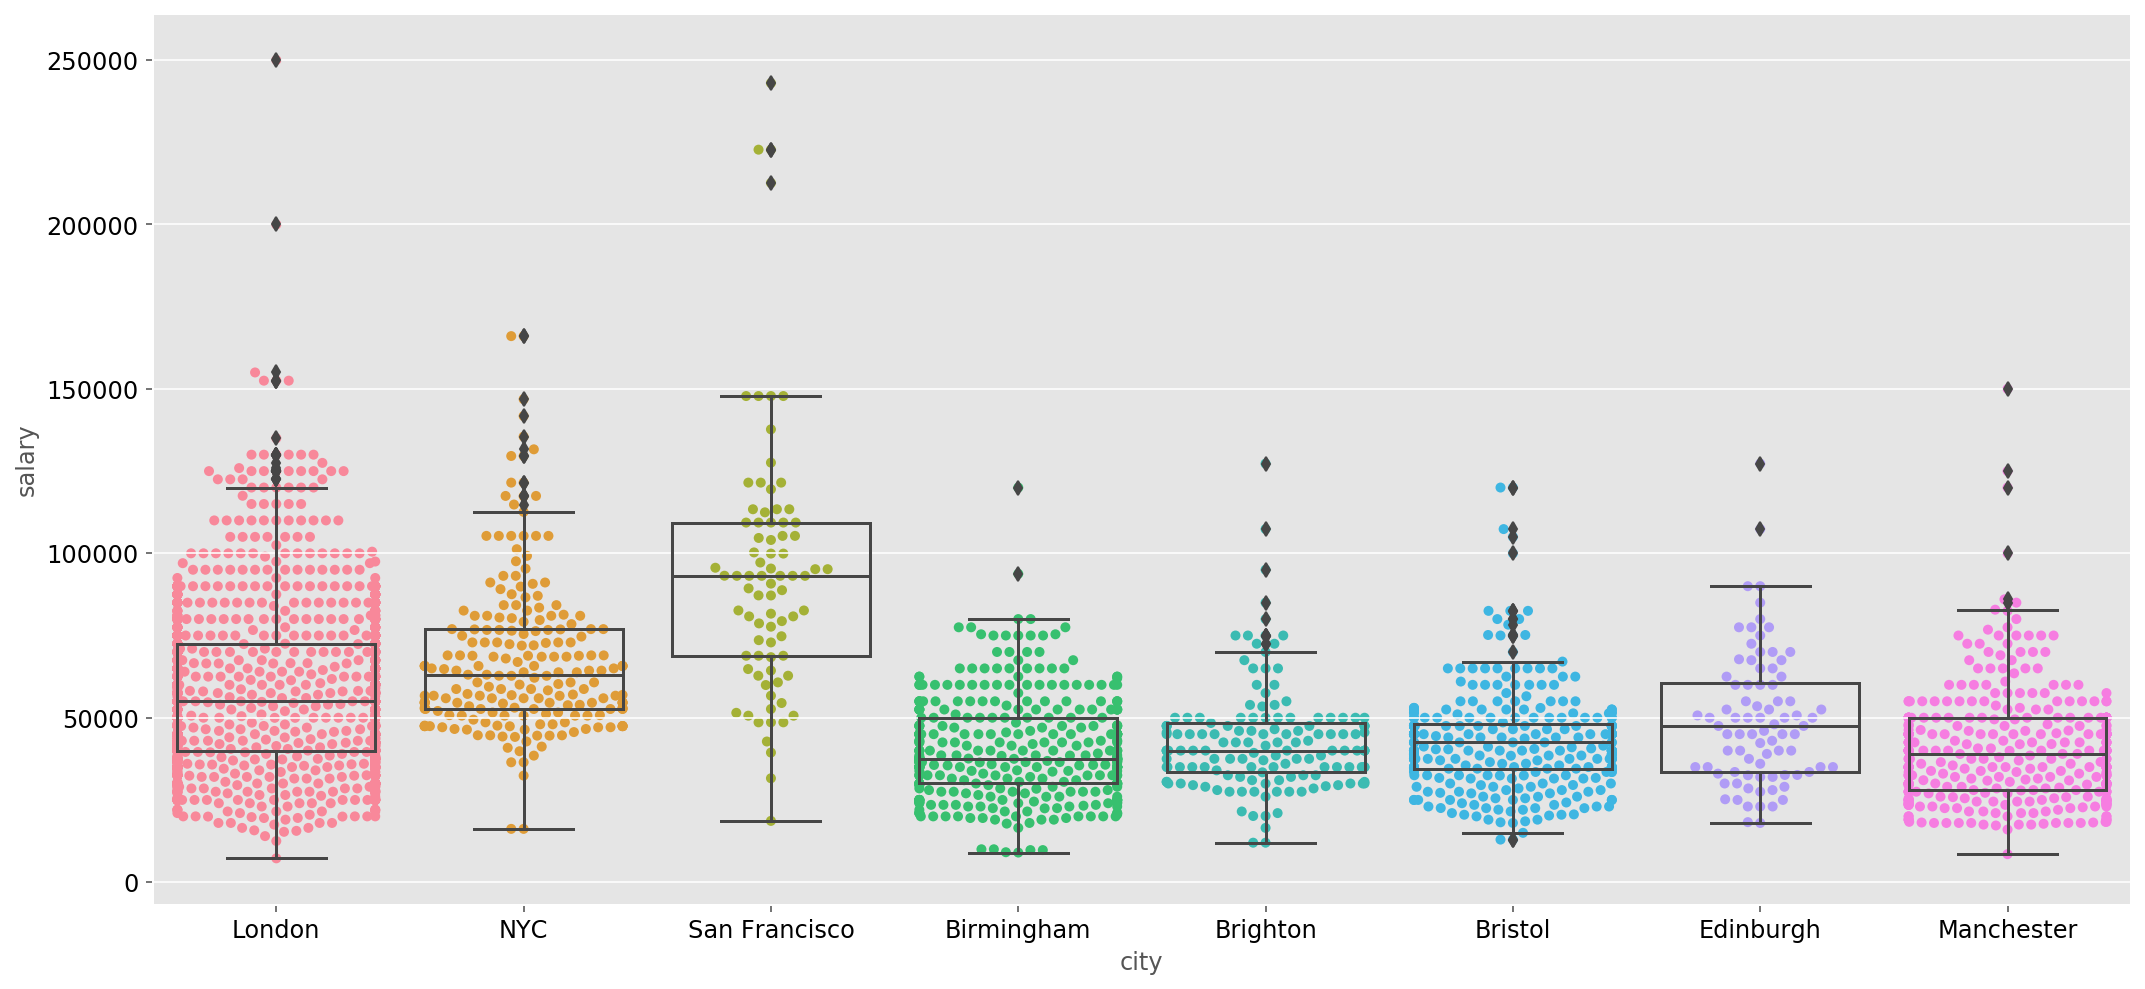

In [13]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(df.city, df.salary, boxprops={'facecolor':'None'}, ax=ax)
sns.swarmplot(df.city, df.salary, zorder=.5, ax=ax)
plt.xticks(fontsize=12, color = 'k')
plt.yticks(fontsize=12, color = 'k')
plt.tight_layout()
plt.savefig('images/city_salary_dist.png', transparent = True)
plt.show()

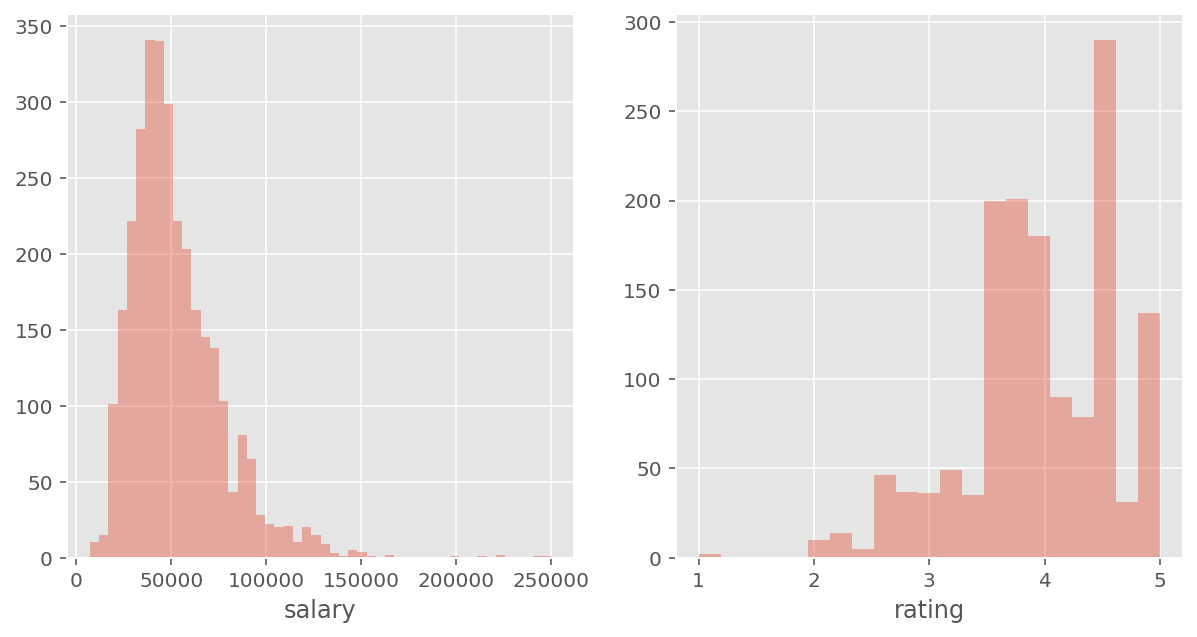

In [14]:
#Observing the distribution of salary and ratings 
ratings_noNull = df.rating.dropna()
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))
sns.distplot(df.salary, kde=False, ax=ax[0])
sns.distplot(ratings_noNull, kde=False, ax=ax[1])
plt.show()

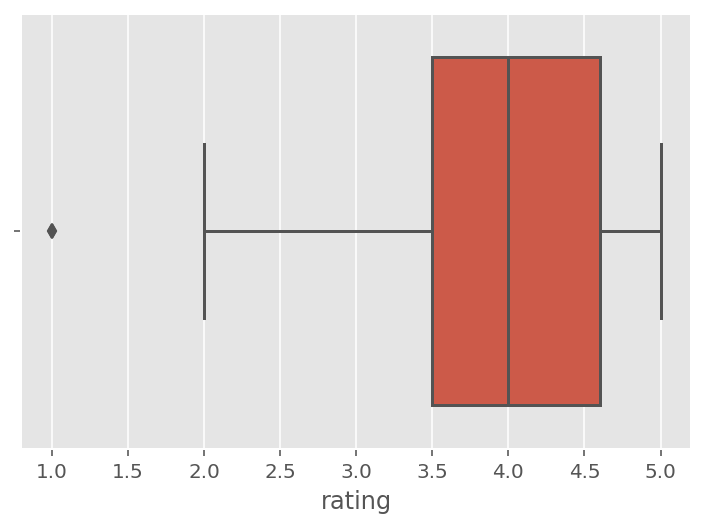

In [15]:
#Analysing the existing rating distribution for feature engineering later on 
sns.boxplot(df.rating)
plt.show()

### Dropping all the irrelavant job titles

Digging around the data showed me a few postings that aren't relevant in the data science field e.g. Weekend Housekeeper. Looking at the salaries below £15000, all of them could be dropped as they weren't relevant. 

I reasoned that there might be more postings that could been scrapped for containing words like "engineer" in their job dsecription. So using regex, I dropped all the rows with words like "technician" in their title without containing words like "data scientist", as there were a few like this e.g. "BIM Technician/Data Scientist".



In [16]:
df[df.salary<15000]

,company,job_title,salary,description,rating,location,city
937,Bunzl Greenham,Warehouse & Branding Operative,12509.0,Spotting and resolving potential problems with designs/transfers or the machines before starting to work to minimise damages and loss.,3.9,London,London
1072,Elysium Healthcare,Weekend Housekeeper,7239.0,"Maintaining floors and carpets throughout the hospital, including deep cleaning through the use of a carpet extraction machine.",3.6,London SE6,London
1077,Push Group Limited,Relationships Director,14000.0,We are looking for high calibre candidates with the ability to build relationships with senior channel partners; you will have in-depth knowledge of machine…,5.0,Uxbridge UB9,London
2014,Machined Component Systems,Production Engineer Apprentice,9750.0,Carry out maintenance and refurbishment of machines.Initiate and develop new ideas to improve machine tooling.Preparing and using Milling Machines.,NaN,Redditch B98,Birmingham
2018,Howard S Cooke & Co Ltd,Press Toolmaker Apprentice,9100.0,"Using CNC Lathes, milling machines and surface grinders to produce complex shapes.For the 2nd year apprentices will attend MGTS on a day release basis to…",NaN,Redditch B98,Birmingham
2023,Machined Component Systems,Setter Operator Apprentice,9750.0,Setting and operating CNC machines to MCS work instructions.The rest of the apprenticeship duration will be spent at Machine Components learning key aspects of…,NaN,Redditch B98,Birmingham
2070,The ITP,Installation and Support Desk Apprentice,9000.0,"They will initially be supported by our senior existing field engineers, who will train them in the installation of data cabling, routers, switches, networks,…",NaN,Birmingham B26,Birmingham
2093,Estio Training,Digital Marketing Apprentice,10000.0,"Using Microsoft Word and Excel to record data.Stop wasting time and money on technology.From hardware to software and support to projects, every solution is…",3.5,Birmingham B16,Birmingham
2171,Estio Technology,Digital Marketing Apprentice,10000.0,Using Microsoft Word and Excel to record data.Please contact Gemma on Gemma.Wallis@estio.co.Stop wasting time and money on technology.,NaN,West Midlands,Birmingham
2259,Just IT Recruitment,IT Network Apprentice,12000.0,"Support staff in adapting and integrating digital learning resources.Perform routine maintenance tasks: e.g. creating images, machine and mouse cleaning, lead…",1.0,Ringmer,Brighton


In [17]:
# All of the jobs below 15000 seemed to be irrelavant based on titles and description
df.drop(df[df.salary<15000].index, inplace=True)

In [18]:
to_drop = df[(df.job_title.str.contains(r'(electrician|technician|attorney|housekeeper)', 
                             flags=re.IGNORECASE)) & 
   ~(df.job_title.str.contains(r'(data|insight|machine learning|quantitative)', 
                             flags=re.IGNORECASE))].index

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [19]:
df.drop(index=to_drop, inplace=True)

In [20]:
df[df.salary>150000]

,company,job_title,salary,description,rating,location,city
74,Consortia,Data Science Director,152500.0,"Data Science Director – Central London - paying up to £165,000 + bonus + flexible working.If you want to be the Data Science Director in this Leadership team,…",NaN,London,London
93,Bodhi Resourcing,Chief Data Scientist,155000.0,"As the Chief Data Scientist, you will be defining the approach, standards, road map and overall strategy of the team expansion to ensure their customer…",NaN,London NW1,London
904,Millar Associates,"Senior Quant, SIMM Model Validation (VP), London",200000.0,"Masters (ideally PhD) educated in a quantitative field (Physics, Maths, Engineering).£££ Highly Competitive Salary Package (Total to £200k).",NaN,London,London
909,Millar Associates,"Fixed Income & Credit Hybrids Quant, (VP & Dir)",250000.0,We seek an experienced Quantitative Analyst for the Fixed Income / Structured Credit trading desk to develop and implement models for pricing & hedging and…,NaN,London,London
1004,Consortia,Data Science Director,152500.0,Advising on the operationalisation of machine learning and data science within this world leading Data Insights company.,NaN,London,London
1363,Consortia,Data Science Director,152500.0,"Attracting and recruiting very capable data scientists and data engineers, and line management and capability development of the team, including twice-yearly…",NaN,London,London
1515,CEDENT,"NLP Development Manager, Wholesale Credit Technology Data An...",166050.0,"Knowledge and strong interest in AI innovation trends, and advanced data analytics software applications.Ability to manage innovative technology projects.",NaN,"New York, NY",NYC
1597,CEDENT,"NLP Development Manager, Wholesale Credit Technology Data An...",166050.0,"Title: NLP Development Manager, Wholesale Credit Technology Data Analytics Group, New York, NY.Terms of Hire: Full Time.",NaN,"New York, NY",NYC
1721,Blue Owl,Data Scientist,222750.0,Demonstrable expertise building and supporting machine learning models deployed to production.You have built time series models using econometric approaches as…,NaN,"San Francisco, CA",San Francisco
1785,Blue Owl,Senior Data Engineer,243000.0,"This includes the rewards system that will be used to increase driver safety, designing APIs, creating/managing databases, and writing automated test suites.",NaN,"San Francisco, CA",San Francisco


In [21]:
df.shape

(3071, 7)

### Feature engineering - Categorising companies

Using the descriptions, job_titles and company names, I tried to categorise the postings into different sectors. These are the sectors I managed to do: recruitment, govt, university, finance and unknown. Given that the preview of the description only contained a few words, it was hard to categorise the companies/job postings accurately beyond these categories.

Firstly it was evident that most of the companies were recruiters as these would be the companies who would tend to post on sites like Indeed. The top 20 companies who had the most number of job postings I classified as 'recruitment' companies. Then using regex and EDA, I sorted the job postings into the categories as best as I could. I proritised all other categories before 'recruitment', e.g. if the company for a job posting was technically a recruitment company but I could identify from the job description it was for a finance client, that job posting would get would get a finance category. 

Just under half the postings still had to be assigned 'unknown' but given more time, I think I could categorised a few more. 

In [22]:
df['sector'] = np.nan

In [23]:
df.sector.isnull().sum()

3071

In [24]:
df.company.value_counts().head(20)

Harnham                                        183
Aspire Data Recruitment                        97 
Michael Page UK                                91 
Ampersand Consulting                           50 
Venturi                                        44 
Inspiring Interns                              39 
Linux Recruit                                  37 
New York City DEPT OF HEALTH/MENTAL HYGIENE    34 
MBN Solutions                                  31 
Client Server                                  30 
Metrica Recruitment                            29 
Datatech Analytics                             26 
Opus Recruitment Solutions                     24 
Consortia                                      24 
Cirrus Selection                               23 
Taylor James Resourcing                        23 
kdr Recruitment                                18 
GCS Recruitment Specialists Ltd                18 
ADLIB                                          18 
Ripjar                         

In [25]:
#Companies in the top 20 for number of postings are recruiters
df.sector.loc[df[df.company.isin(df.company.value_counts().head(20).index)].index] = 'recruitment'

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
df.sector.loc[df[(df.company.str.contains(
    r'(council|borough|New York City|government|HM Revenue|Bank of England|Nuclear|NHS|Ministry|Metropolitan|County)', 
    flags=re.IGNORECASE))].index] = 'govt'

In [27]:
df.sector.loc[df[(df.company.str.contains(r'(university|college|school)', 
                                         flags=re.IGNORECASE))].index] = 'university'

In [28]:
df.sector.loc[df[(df.description.str.contains(r'(finance|financial|banking|fintech|financial services|insurance)', 
                                         flags=re.IGNORECASE)) | 
                 (df.company.str.contains(r'(banking)', 
                                         flags=re.IGNORECASE))].index] = 'finance'

In [29]:
df.sector.loc[df[(df.sector.isnull()) & ((df.company.str.contains(
    r'(talent|recruitment|solutions|(?<!re)search|people|resourcing|recruit|selection)', flags=re.IGNORECASE)) |
    (df.description.str.contains(r'(client)', flags=re.IGNORECASE)))].index] = 'recruitment'

In [30]:
df[df.sector.isnull()].company.value_counts().head(20)

Oscar Technology                15
BT                              15
Gregory-Martin International    13
Douglas Jackson                 12
Hasson Associates               10
Blue Owl                        10
ShareForce                      10
Bettor Believe                  9 
McGregor Boyall                 9 
Moonshot CVE Ltd                8 
Oho Group                       8 
Rovco                           8 
SF Group                        8 
Harnham US                      7 
Migacore Technologies           7 
re&m                            7 
Robert Half United Kingdom      7 
Proactive.IT Appointments       7 
Pearson Frank                   6 
Velocity Black                  6 
Name: company, dtype: int64

In [31]:
df.sector.loc[df[df.sector.isnull()].index] = 'unknown'

In [32]:
df.sector.isnull().sum()

0

### Feature engineering - Cleaning up ratings
Firstly I decided to clean up the ratings for the companies that were listed. Some job posts had null values despite other job posts for the same company having rating information. So I made sure all of the job posts for a company that had rating information were filled. One company had two ratings but I left this in as this rating was different for different geographical branches of the company. 

As half of the job posts had no rating information even after this clean up, I decided to make a new columns, rating_t, with 4 categories (None, Low, Medium & High). I used the distribution of original rating column to split the job posts with rating into Low, Medium & High with roughly a third of the data for each label. 

In [33]:
ratings_correct = []
for company in df.company.value_counts().index:
    if len(df[(df.company == company)]['rating'].unique()) > 1:
        ratings_correct.append(company)
ratings_correct

['Michael Page UK',
 'Cirrus Selection',
 'GCS Recruitment Specialists Ltd',
 'Lloyds Banking Group',
 'BT',
 'Velocity Black',
 'Meltwater',
 'Talent International',
 'TechNET IT Recruitment Ltd',
 'Euromonitor',
 'Capita IT Resourcing']

In [34]:
df.loc[df.company.isin(ratings_correct)].groupby(['company', 'location'])['rating'].unique()

company                          location           
BT                               Bristol                [3.8, nan]
                                 London                 [3.8]     
                                 Manchester             [3.8]     
                                 Skelmersdale           [3.8]     
Capita IT Resourcing             Manchester             [3.5]     
                                 Staines-upon-Thames    [3.6]     
Cirrus Selection                 Bristol                [5.0, nan]
Euromonitor                      London                 [3.8, nan]
GCS Recruitment Specialists Ltd  Birmingham             [5.0]     
                                 Burgess Hill           [5.0]     
                                 Edinburgh              [5.0]     
                                 London                 [5.0, nan]
                                 Staines-upon-Thames    [5.0]     
                                 West Midlands          [5.0]     
Lloyds Ba

In [35]:
#All but Capital IT Resourcing, have the same ratings across all locations so I made sure all of them have the 
#the same ratings but Capital. While this shouldnt matter too much about the company itself as these are mostly
#recruitment companies, it is a good way to fill in the null values.

df.rating = df.groupby('company')['rating'].transform(lambda x: x.fillna(x.max()))

In [36]:
#Converting the rating columns into something more manageable: None, Low(=<3), Medium (=<4) and High(>4)
df['rating_t'] = df.rating.map(lambda x: 'None' if np.isnan(x) else ('Low' if x<=3.6 else ('Medium' if x<=4.3 else 'High')))


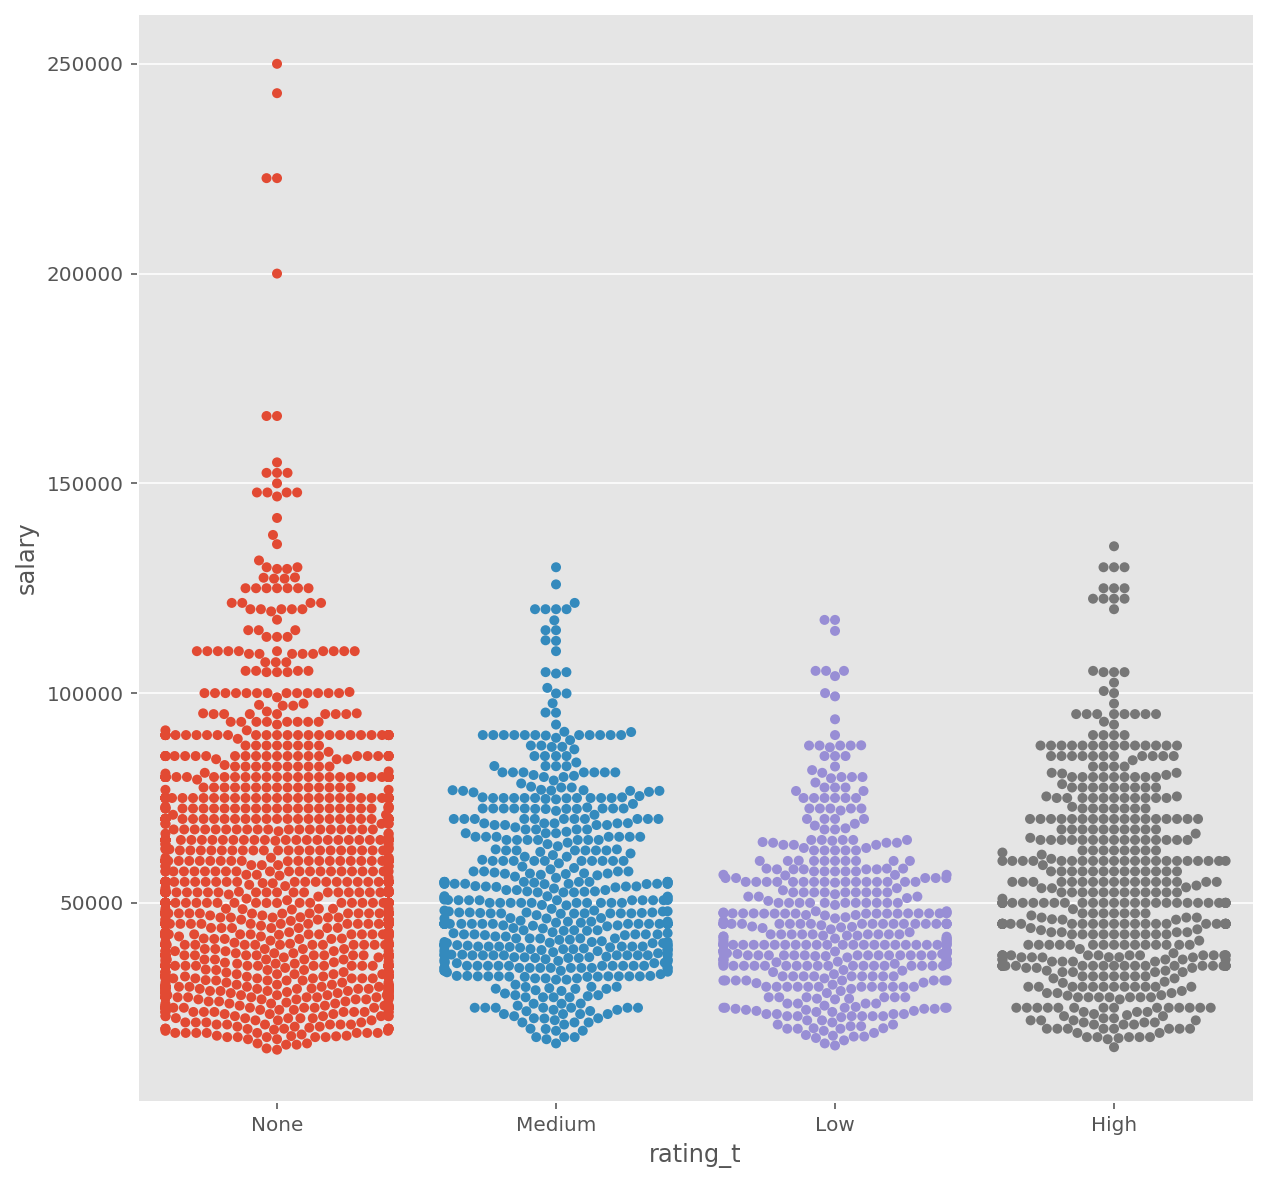

In [37]:
plt.figure(figsize=(10,10))
sns.swarmplot(df.rating_t, df.salary)
plt.show()

### Feature engineering - Classifiying roles

Using more regex and EDA, I created 8 other columns to capture information about the role: senior, junior, head, ai, data_engineer, other_engineer, data_science and analyst. Few observations:

- I had to create data_engineer and other_engineer seperately because the scraping also pulled other kinds of engineering roles such as software development or more hand-ons engineering and hence I had to seperate the two as they would be paid very differently. This is reflected in the bar plot of the mean salaries for each type of role at the bottom. 

- Senior ranked lower than data_engineer, data_science and ai as the job postings had roles for senior managers that also included roles in software engineering that tend to be pay lower, hence bringing down the average for senior roles when compared to the average salary of the roles requiring data science. 

- Otherwise, the correlation heatmap and the bar plot was pretty much in line with my expectations. E.g. salary is negatively correlated with jobs containing the words 'junior' and 'analyst' vs jobs containing 'senior' and so on. |

In [38]:
df['senior']  = 0
df['junior'] = 0
df['head'] = 0
df['ai'] = 0
df['data_engineer'] = 0
df['other_engineer'] = 0
df['data_science'] = 0
df['analyst'] = 0

In [39]:
df.senior.loc[df[(df.job_title.str.contains(r'(senior|manager|lead)', 
                                         flags=re.IGNORECASE))].index] = 1

In [40]:
df['head'].loc[df[(df.job_title.str.contains(r'(head|director|chief)', flags=re.IGNORECASE))].index] = 1

In [41]:
df.junior.loc[df[(df.senior == 0) & ((df.job_title.str.contains(r'(graduate|junior|student|intern)', flags = re.IGNORECASE))
   | df.description.str.contains(r'graduate|junior|intern|student', flags=re.IGNORECASE))].index] = 1

In [42]:
df.ai.loc[df[(df.job_title.str.contains(r'(\bAI\b|NLP|machine learning|deep)', flags = re.IGNORECASE))
            |(df.description.str.contains(r'(deep|machine learning|\bAI\b|nlp|\bML\b)', flags = re.IGNORECASE))].index] = 1

In [43]:
df.other_engineer.loc[df[df.job_title.str.contains(
    r'^(?!.*(data|machine learn|nlp|natural language|\bai\b|deep|vision)).*engineer.*$', 
    flags = re.IGNORECASE)].index] = 1 

In [44]:
df.data_engineer.loc[df[df.job_title.str.contains(
    r'^(?=.*(data|machine learn|nlp|natural language|\bai\b|deep|vision)).*engineer.*$', 
    flags = re.IGNORECASE)].index] = 1 


In [45]:
df.data_science.loc[df[(df.job_title.str.contains(r'data scien', flags = re.IGNORECASE)) | 
   (df.description.str.contains(r'data scien', flags = re.IGNORECASE))].index] = 1

In [46]:
df.analyst.loc[df[df.job_title.str.contains(r'analyst', flags = re.IGNORECASE)].index] = 1

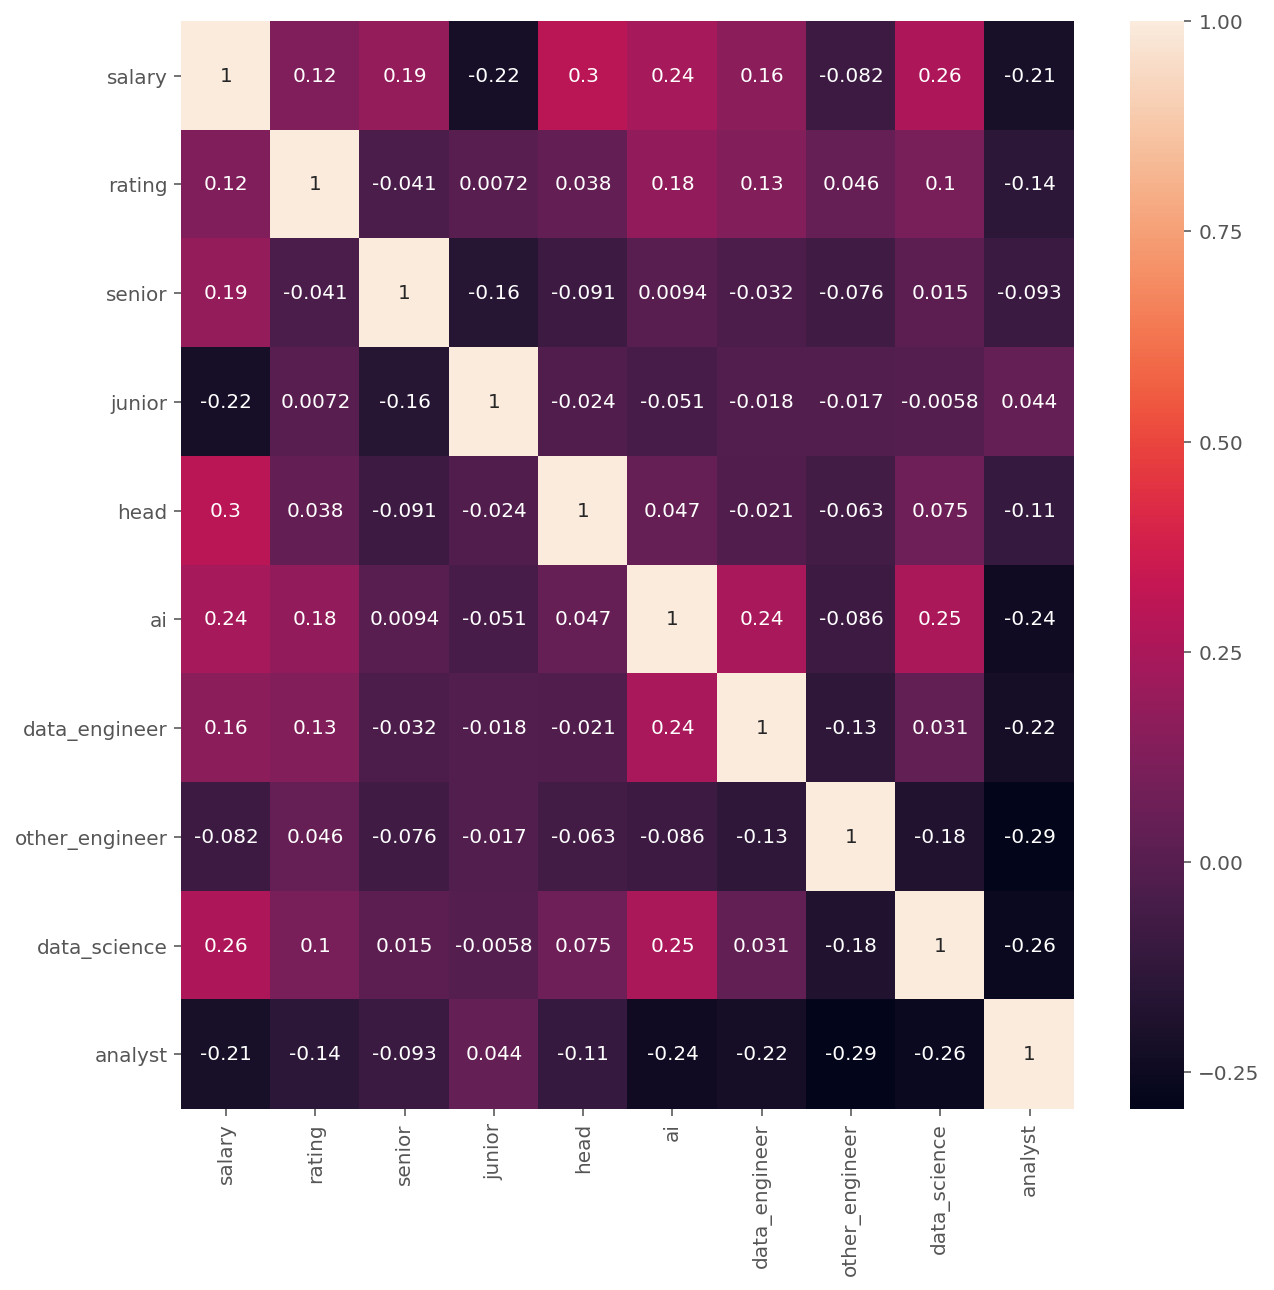

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

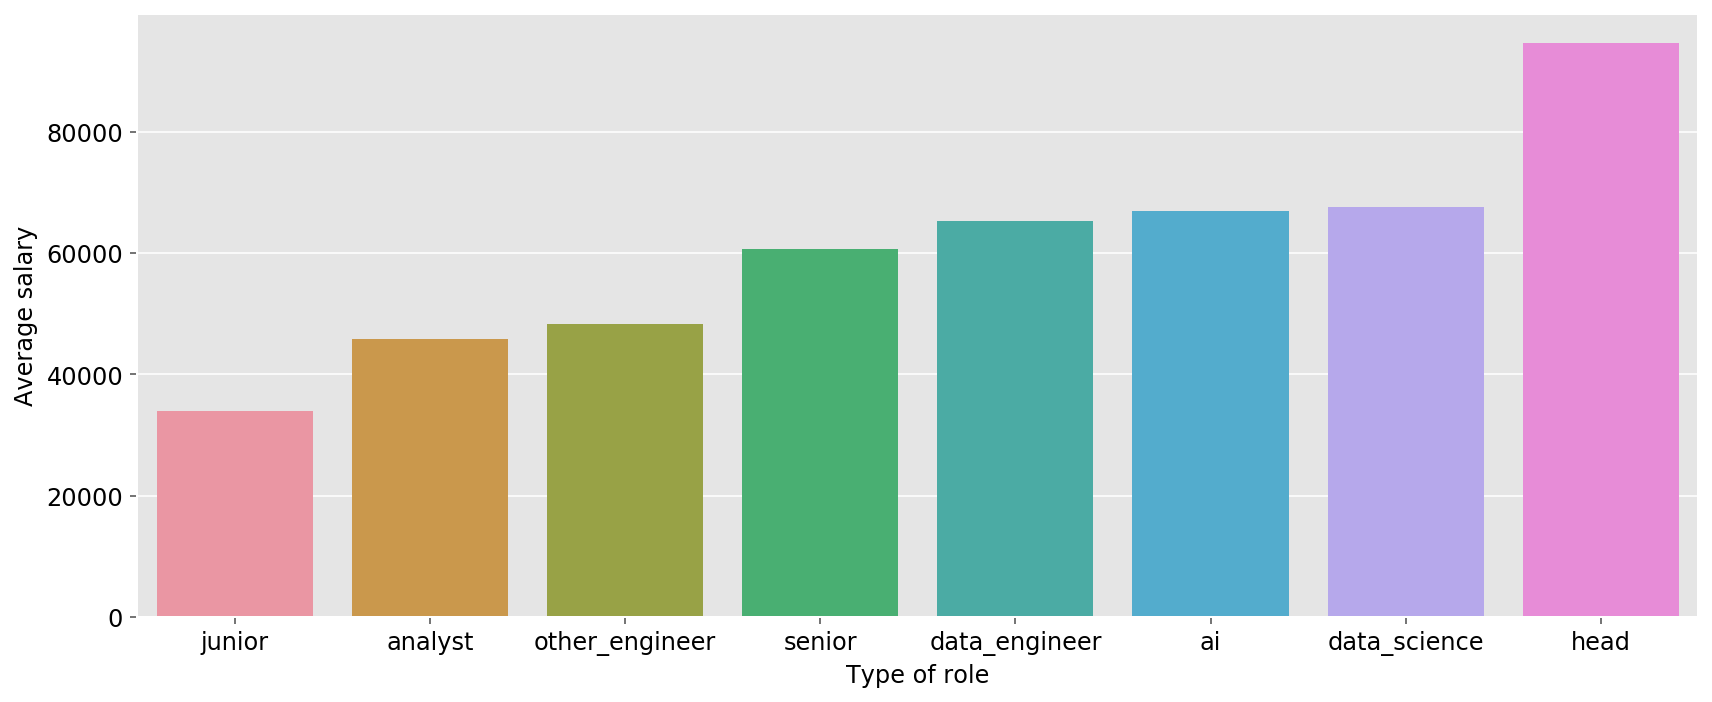

In [50]:
added_features = ['senior', 'junior', 'head', 'ai', 'data_engineer', 'other_engineer', 'data_science', 'analyst']
mean_salaries = [df[df[col]==1].salary.mean() for col in added_features]
mean_df = pd.DataFrame(list(zip(added_features, mean_salaries))).sort_values(by=[1])
plt.figure(figsize=(12,5))
sns.barplot(mean_df[0], mean_df[1])
plt.xticks(fontsize=12, color = 'k')
plt.yticks(fontsize=12, color = 'k')
plt.xlabel('Type of role', fontsize=12, color='k')
plt.ylabel('Average salary', fontsize=12, color='k')
plt.tight_layout()
plt.savefig('images/roles.png', transparent = True)
plt.show()

### Using NLP on job_title and description

Using the job_title and description, I used the TfidVectorizer (after experimenting with the paramters), removing all the stop words, allowing 2 word phrases (ngram_range) to allow for more context and setting a maximum of 15000 features. 

In [51]:
text = df.job_title + ' ' + df.description
text

0       Data Scientist WHAT WILL YOU BE DOING?My client is looking for an exceptional data scientist to join their Data & Analytics team.Ideal needs for this role….                                                        
1       Data Scientist As a service design-focused Data Scientist working on Universal Credit, you will own projects that turn data into insights and recommendations that directly…                                        
2       Junior Data Scientist Data Analysis, Data Science, Graduate Analyst.Python, SQL, Excel, Power BI, Tableau.My client are have partnered with Michael Page in their search for a team…                                
3       Data Science Graduate Scheme You will be tasked with turning huge amounts of data into actionable insights.The next step from here will be to start producing predictive models to help the…                        
4       Data Scientist We’re looking for a Data Scientist to help us make job search better using the power of data.

In [52]:
tvec = TfidfVectorizer(stop_words='english', max_features = 15000, ngram_range=(1, 2), strip_accents='unicode')

tvec.fit(text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=15000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [53]:
text_csr = tvec.transform(text)

In [54]:
text_df = pd.DataFrame(text_csr.todense(),
                  columns=tvec.get_feature_names())
text_df.transpose().sort_values(0, ascending=False).transpose()

,needs role,looking exceptional,doing,join data,data scientist,scientist,scientist join,ideal,exceptional,analytics team,...,infrastructure engineers,infrastructure including,infrastructure libraries,infrastructure security,infrastructure server,infrastructure support,infrastructure team,ingestion,ingestion data,zero track
0,0.328934,0.301585,0.292781,0.279506,0.259891,0.253301,0.244497,0.242242,0.240109,0.229281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.235243,0.229278,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.092821,0.090467,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.192777,0.187889,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating y

I split the salary variable to into the respective quartiles. The baseline accuracy is ~0.26 as expected as I split the target variable equally into 4 pieces across its distribution.

In [55]:
#converting the problem intoa 4-class classification problem 
y = df.salary.map(lambda x: 0 if x<=salary_25 else(1 if x<=salary_median else(2 if x<=salary_75 else 3)))
y

0       1
1       1
2       1
3       0
4       1
       ..
3098    2
3099    1
3100    0
3101    2
3102    0
Name: salary, Length: 3071, dtype: int64

In [56]:
y_check = df.salary.map(lambda x: 0 if x<= salary_median else 1)

In [57]:
#Baseline accuracy will be more or less close the 1/number of levels
y.value_counts(normalize=True)

1    0.263758
2    0.250733
0    0.243243
3    0.242266
Name: salary, dtype: float64

### Using all predictor variables 

This is where the fun really began! I ran countless GridSearches on a number of models with many different parameters and satisfyingly (lol not!), the best model was good old Logistic Regression with Ridge! 

This is how I decided which model was the "best":

- Mean CV Score: This measures the accuracy of the models but in classification, accuracy isn't all we should be concerned about. 


- Confusion Matrix Percentage/Count: This is a score I made up to track how well the model minimises the lower right hand triangle of the confusion matrix - specifically for the test set. This project brief specifies that the boss is concerned with prediciting a higher class when the actual value is in a lower class. This effectively means you want the lower right hand side triangle of the confusion matrix to be minimised. I added up these values and divided through by the number of samples to get the fraction of lower right hand triangle. I only judged this score based on the test set because the train set would be very overfit and would hard to meaningfully try to optimise based on this as the confusion matrix would be near perfect.

In this brief, we want to maxmise both the precision and recall score given there are multiple classes. Running the GridSearch with scoring method f1_micro didn't make much of a difference to the confusion matrix so I first ran all of the models and judged the best one based on the accuracy score. Then for this model, Logisitic Regression, I tried a few methods to try to minise the confusion matrix percentage score while keeping the accuracy score as high as possible. 

More detail to follow - I only explained the steps in Logisitic Regression in detail as this was the best model. I have included and sectioned the code for the rest of the models below! 

#### Creating a full predictor variable  - with NLP
After dropping all but the categorical and the binary columns, I dummified the predictor matrix and converted it into a compressed sparse row matrix. I stacked the matrix created by the TFiDVectorizer together with this predictor matrix to create the full predictor matrix in csr form - this would also help make computation a little faster. I didn't standardise the data as they were all pretty much on the same scale. 

In [58]:
X = df.copy()

In [59]:
X.drop(columns = ['job_title', 'company', 'salary','description', 'rating', 'location'], inplace=True)
X

,city,sector,rating_t,senior,junior,head,ai,data_engineer,other_engineer,data_science,analyst
0,London,recruitment,None,0,0,0,0,0,0,1,0
1,London,govt,Medium,0,0,0,0,0,0,1,0
2,London,recruitment,Low,0,1,0,0,0,0,1,0
3,London,unknown,None,0,1,0,0,0,0,1,0
4,London,unknown,None,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3098,Manchester,unknown,Low,1,0,0,0,0,0,0,0
3099,Manchester,recruitment,None,0,0,0,0,0,1,0,0
3100,Manchester,finance,None,0,0,0,0,0,0,0,0
3101,Manchester,recruitment,None,1,0,0,0,0,0,0,0


In [60]:
X_dum = pd.get_dummies(X, drop_first = True)
X_dum

,senior,junior,head,ai,data_engineer,other_engineer,data_science,analyst,city_Brighton,city_Bristol,...,city_Manchester,city_NYC,city_San Francisco,sector_govt,sector_recruitment,sector_university,sector_unknown,rating_t_Low,rating_t_Medium,rating_t_None
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3099,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3100,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3101,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


0       1
1       1
2       1
3       0
4       1
       ..
3098    2
3099    1
3100    0
3101    2
3102    0
Name: tar, Length: 3071, dtype: int64

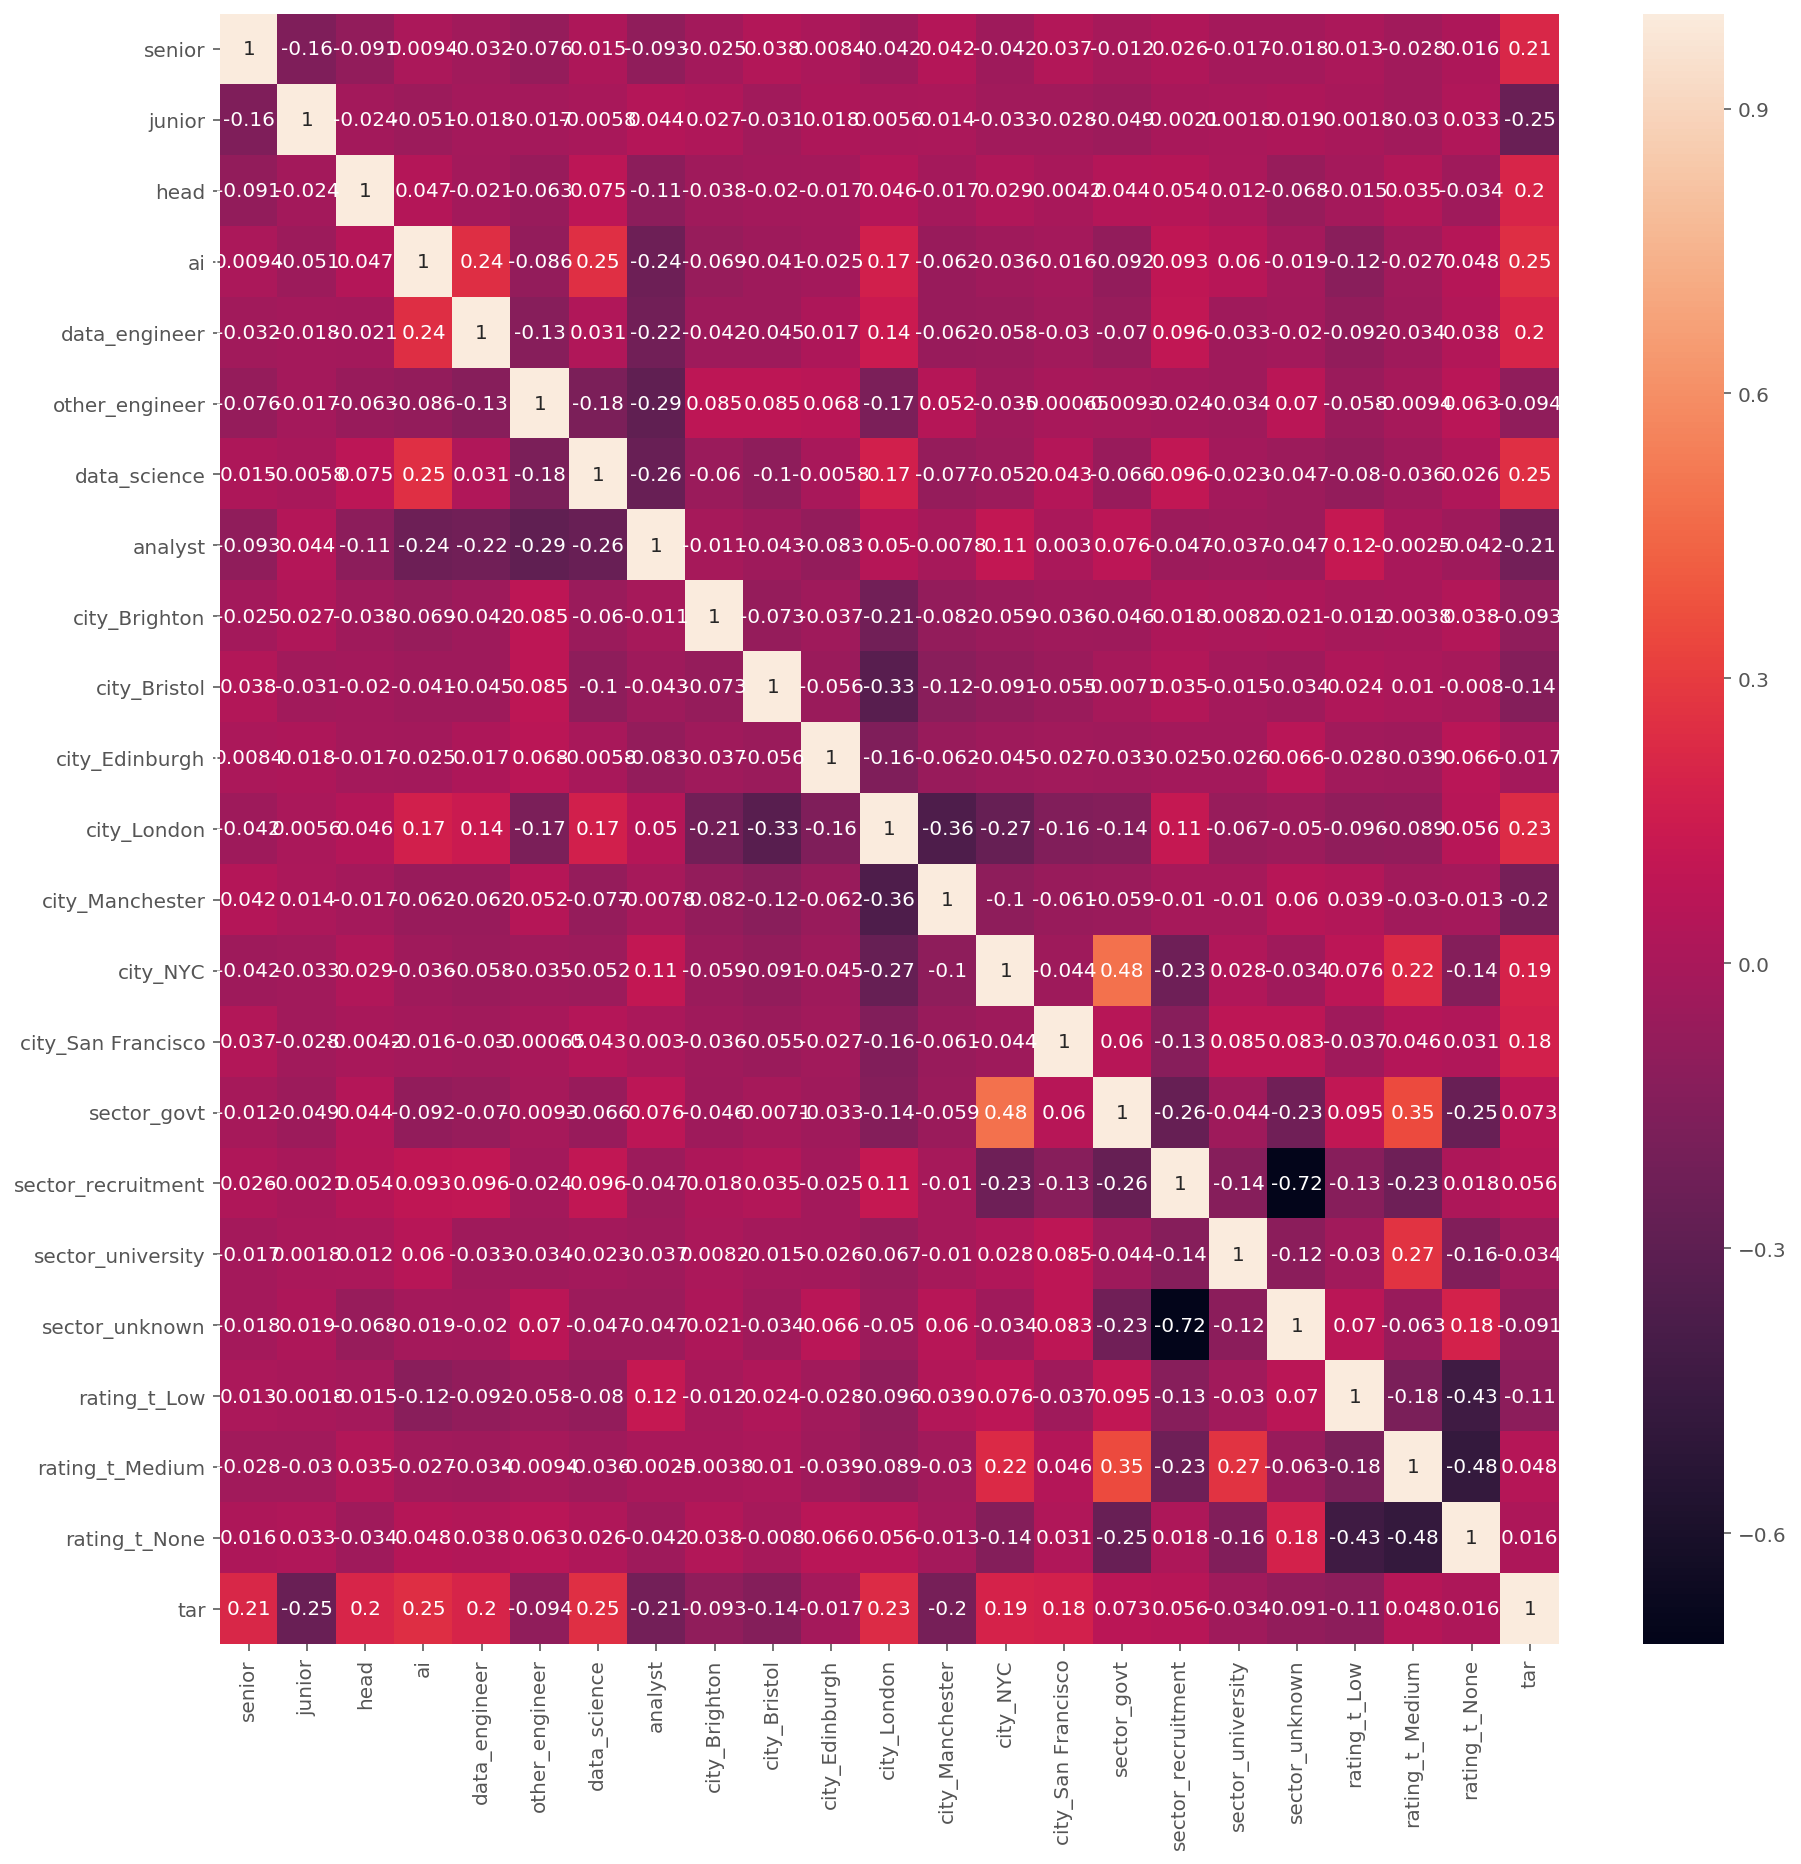

In [61]:
X_dum['tar']=y.copy()
plt.figure(figsize=(15,15))
sns.heatmap(X_dum.corr(), annot=True)
X_dum.pop('tar')

In [62]:
X_csr = sc.sparse.csr_matrix(X_dum.values)
X_full = sc.sparse.hstack([X_csr, text_csr])

pd.DataFrame(X_full.todense()).head()

,0,1,2,3,4,5,6,7,8,9,...,15012,15013,15014,15015,15016,15017,15018,15019,15020,15021
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size = 0.2, stratify = y, random_state=1)

#### Logistic Regression - 0.60487 - with gridsearch - 97 (<15%)

Logistic Regression with Ridge regularization (l2) was the best modelw with an original mean cv score of ~0.589 and confusion matrix count at 153 datapoints in the lower right hand triangle (26.8%% of the 615 datapoints in the test set). This model had the accuracy score and one of the lowest conf matrix percentage - decision tress had a the lowest score here. I decided to chose Log Reg and use different methods (probablity thresholds and class weights) to bring the confusion matrix percentage score down.

The confusion matrix percentage threshold can be set as anything, e.g. I decided that I wanted more than 15% of the data to be in the lower right hand triangle. But in theory, the boss could set this at any value. But this could come at the cost of the accuracy score. I explain this in more detail below.

The best model returned a score of 0.60487!

##### Using GridSearch to find the optimal Log Reg

In [64]:
logreg = LogisticRegression(solver='liblinear', multi_class='ovr', class_weight = {0:1, 1:1, 2:2, 3:2})

In [65]:
params = {'C': np.logspace(-0.5, 0.5, 15),
          'penalty': ['l1', 'l2']}

gs_logreg = GridSearchCV(estimator=logreg,
                  param_grid=params,
                  cv=5,
                  n_jobs =2,
                  verbose = 1,
                  scoring='accuracy',
                  return_train_score=True)

gs_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   14.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0,
                                          class_weight={0: 1, 1: 1, 2: 2, 3: 2},
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': array([0.31622777, 0.37275937, 0.43939706, 0.51794747, 0.61054023,
       0.71968567, 0.8483429 , 1.        , 1.17876863, 1.38949549,
       1.63789371, 1.93069773, 2.27584593, 2.6826958 , 3.16227766]),
                         'penalty': ['l1', 'l2']},
      

In [66]:
gs_logreg.best_estimator_

LogisticRegression(C=3.1622776601683795, class_weight={0: 1, 1: 1, 2: 2, 3: 2},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='ovr', n_jobs=None,
                   penalty='l2', random_state=None, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

In [67]:
gs_logreg.best_params_

{'C': 3.1622776601683795, 'penalty': 'l2'}

In [68]:
print(gs_logreg.best_estimator_.score(X_train, y_train))
print(gs_logreg.best_estimator_.score(X_test, y_test))
print(gs_logreg.best_score_)

0.9670195439739414
0.6178861788617886
0.5875374629510043


##### Evaluating the model using the confusion matrix
As you can see, the confusion matrix for train set is near perfect so it is better to use test set to evaluate the confusion matrix percentage score. Without any modifications, the optimal Log Reg gives 153 data points which is ~0.256% of the test set.

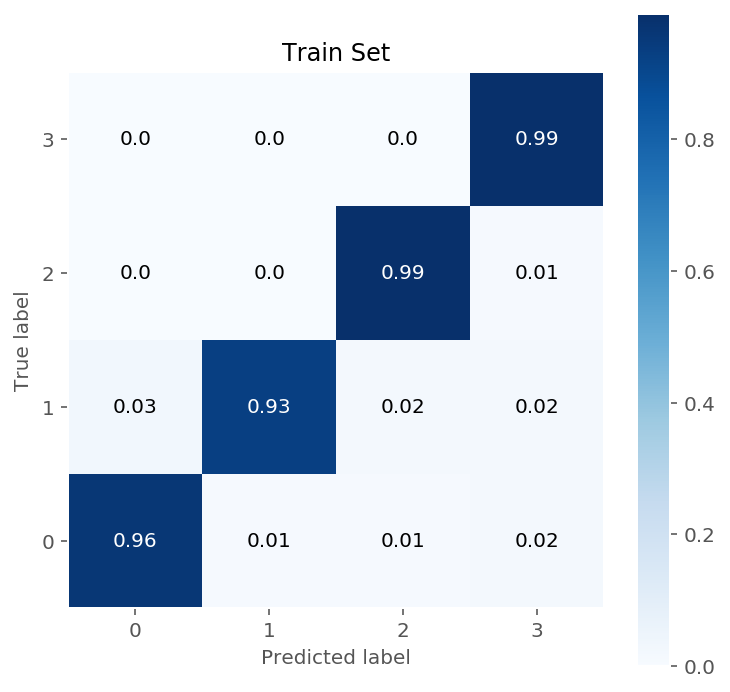

In [69]:
cmap = ListedColormap(sns.color_palette("husl", 4))
skplt.metrics.plot_confusion_matrix(y_train, gs_logreg.best_estimator_.predict(X_train), figsize=(6,6), title = 'Train Set', normalize = True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

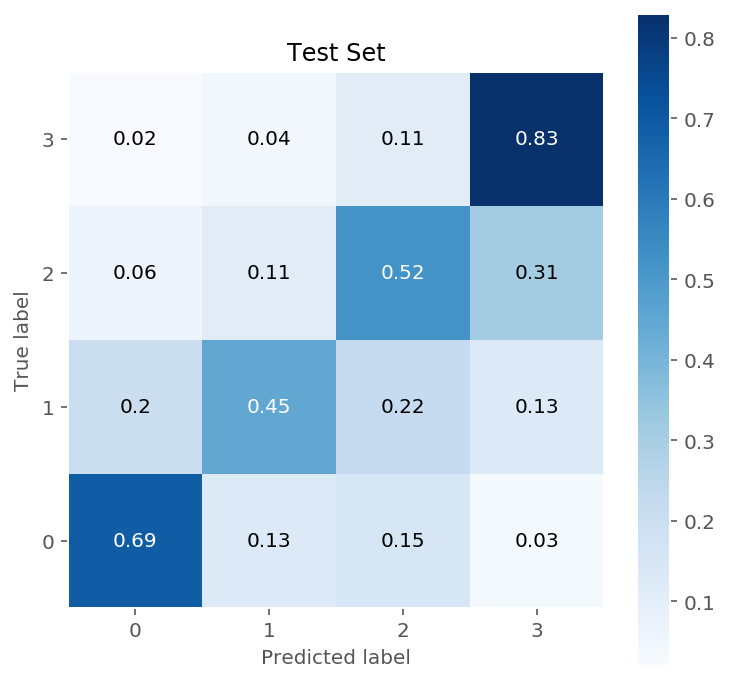

In [70]:
skplt.metrics.plot_confusion_matrix(y_test, gs_logreg.best_estimator_.predict(X_test), figsize=(6,6), title = 'Test Set', normalize=True)
plt.ylim([-0.5, len(y_test.unique())-0.5])
plt.show()

In [71]:
conf_mat= np.triu(confusion_matrix(y_test, gs_logreg.best_estimator_.predict(X_test)), k = 1)
print(conf_mat.sum().sum())
conf_mat

151


array([[ 0, 20, 23,  4],
       [ 0,  0, 36, 21],
       [ 0,  0,  0, 47],
       [ 0,  0,  0,  0]])

##### Experimenting with the probability thresholds for each class
Looking at the confusion matrix, we can see that the model has trouble prediciting the middle two classes. This is also evident when you look at the ROC curve (plotted at the bottom of this Log Reg section). 

Although for multi-class problems, Log Reg uses one-vs-rest approach to classifying the classes, the outputed probabilites are normalized across the classes to add up to 1. Using these probablities and the confusion matrix, we can do more analysis to see how to minimise this lower right hand triangle. 

In particular, when the highest probablity for datapoint is class 3, we want to check what the probability for class 2, 1 or 0 is. Similarly, when the highest probablity for datapoint is class 2, we want to check what the probability for class 1 or 0 is. 

So we can try to manipulate the predictions such that before predicting a class, it checks the difference in probabilites for a lower class, and only assigns the higher class if the difference in probability is more than 0.1 (or whatever threshold you set, I started with 0.1). Otherwise, it assigns it to a lower class. Now this with increase the upper left hand triangle of the confusion matrix (increasing the likelihood of under-predicting a salary) and hence have an effect on the accuracy score (as well as the precision and recall score) but that is the trade-off to make to avoid over-predicting salaries. 

As mentioned before, I started by testing a threshold of 0.1 and then iterated through many different thresholds while recording the accuracy score and confusion matrix percentage for each. 

I decided to set a maximum confusion matrix percentage of 15% (meaning the lower right hand triangle had only have 15% of the test set datapoints) which gave me a threshold of 0.254545 and an accuracy score of 0.569106 - you can check the accuracy scores for other confusion matrix percentages in the tracker dataframe. Not bad of a trade off in accuracy score to reduce the confusion matrix percentage from 26.8% to 15%. I have also plotted the graph to show this trade off (I inverted the confusion matrix percentage axis to show the negative relationship).

However, I also wanted to experiment with class weights to see if that would help reduce the impact on the score while keeping the 15% limit. This is explained in the next section.


In [72]:
#Create a probability dataframe
prob_df = pd.DataFrame(gs_logreg.best_estimator_.predict_proba(X_test), columns = [0, 1, 2, 3])
prob_df['acc_values'] = y_test.values
prob_df['pred_values'] = gs_logreg.best_estimator_.predict(X_test)
prob_df[(prob_df.acc_values != prob_df.pred_values) & (prob_df.acc_values < prob_df.pred_values)]

,0,1,2,3,acc_values,pred_values
0,0.055565,0.316453,0.349199,0.278783,0,2
4,0.266285,0.304160,0.423835,0.005721,1,2
6,0.058430,0.648775,0.240825,0.051971,0,1
9,0.051957,0.388847,0.110626,0.448569,1,3
27,0.116359,0.137444,0.606120,0.140077,1,2
...,...,...,...,...,...,...
594,0.068670,0.387943,0.462180,0.081207,0,2
596,0.163975,0.173950,0.456766,0.205309,0,2
597,0.201361,0.349134,0.380630,0.068874,0,2
612,0.272268,0.293478,0.397922,0.036332,1,2


In [73]:
#Test with 0.1 threshold
probabilities = prob_df.iloc[:, :4].copy()
new_pred = []
value = 0.01
for each in probabilities.values:
    pred = np.where(each == each.max())[0]
    if pred == 3:
        if each[pred]-each[pred-1] > value:
            new_pred.append(pred[0])
        else:
            new_pred.append(pred[0]-1)
            
    elif pred ==2:
        if each[pred]-each[pred-1] > value:
            new_pred.append(pred[0])
        else:
            new_pred.append(pred[0]-1)
    
    elif pred ==1:
        if each[pred]-each[pred-1] > value:
            new_pred.append(pred[0])
        else:
            new_pred.append(pred[0]-1)
    else:
        new_pred.append(pred[0])    

In [74]:
#Add the new predictions and check the impact 
prob_df['new'] = new_pred
prob_df[(prob_df.acc_values < prob_df.pred_values) & 
        (prob_df.acc_values ==0)& (prob_df.pred_values ==1)].sort_values(by=[1, 0], ascending = False)

,0,1,2,3,acc_values,pred_values,new
6,0.058430,0.648775,0.240825,0.051971,0,1,1
501,0.062183,0.639579,0.253761,0.044477,0,1,1
358,0.217549,0.630468,0.092559,0.059424,0,1,1
245,0.226114,0.555510,0.209322,0.009055,0,1,1
83,0.297486,0.551226,0.146718,0.004570,0,1,1
512,0.355977,0.534592,0.039144,0.070288,0,1,1
491,0.376654,0.534519,0.076869,0.011958,0,1,1
558,0.440852,0.479281,0.063092,0.016774,0,1,1
156,0.178583,0.473315,0.340682,0.007419,0,1,1
179,0.405853,0.467723,0.117976,0.008449,0,1,1


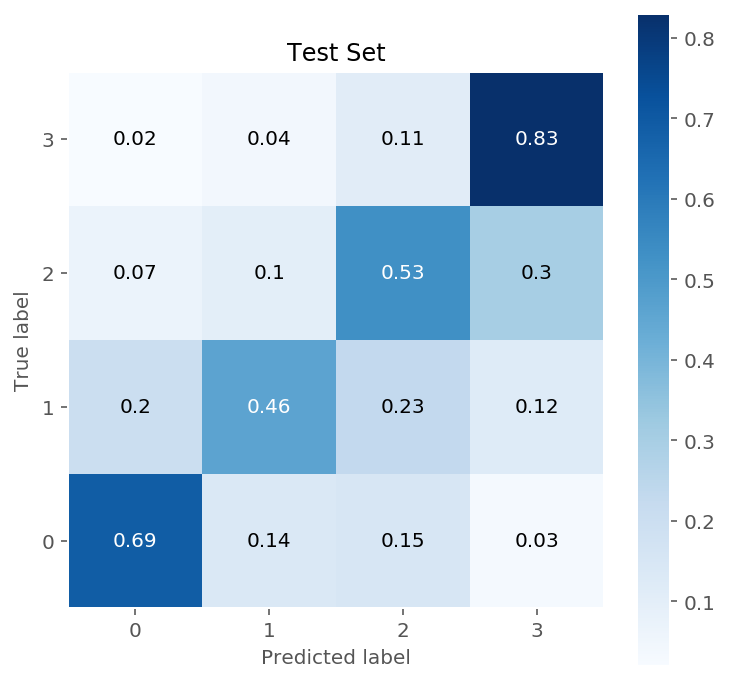

In [75]:
skplt.metrics.plot_confusion_matrix(y_test, prob_df['new'], figsize=(6,6), title = 'Test Set', normalize=True)
plt.ylim([-0.5, len(y_test.unique())-0.5])
plt.show()

In [76]:
conf_mat= np.triu(confusion_matrix(y_test,prob_df['new']), k = 1)
print(conf_mat.sum().sum()/len(y_test), conf_mat.sum().sum())
conf_mat

0.24227642276422764 149


array([[ 0, 21, 22,  4],
       [ 0,  0, 37, 19],
       [ 0,  0,  0, 46],
       [ 0,  0,  0,  0]])

In [78]:
print(metrics.accuracy_score(y_test, prob_df['new']))

0.6211382113821138


In [79]:
#Iterate through many thresholds and produce the tracker datafrane to pick your optimal value.
conf_score = []
accuracy = []
threshold = np.linspace(0.05, 0.5, 45)

for value in threshold:
    new_pred = []
    for each in probabilities.values:
        pred = np.where(each == each.max())[0]
        if pred == 3:
            if each[pred]-each[pred-1] >= value:
                new_pred.append(pred[0])
            else:
                new_pred.append(pred[0]-1)

        elif pred ==2:
            if each[pred]-each[pred-1] >= value:
                new_pred.append(pred[0])
            else:
                new_pred.append(pred[0]-1)

        elif pred ==1:
            if each[pred]-each[pred-1] >= value:
                new_pred.append(pred[0])
            else:
                new_pred.append(pred[0]-1)
        else:
            new_pred.append(pred[0]) 

    conf_score.append(np.triu(confusion_matrix(y_test,new_pred), k = 1).sum().sum())
    accuracy.append(metrics.accuracy_score(y_test, new_pred))
tracker = pd.DataFrame(list(zip(conf_score, np.array(conf_score)/len(y_test), accuracy, threshold)),
             columns = ['conf_score', 'conf_score_per',  'accuracy', 'threshold'])

tracker

,conf_score,conf_score_per,accuracy,threshold
0,140,0.227642,0.609756,0.050000
1,137,0.222764,0.613008,0.060227
2,135,0.219512,0.606504,0.070455
3,129,0.209756,0.608130,0.080682
4,124,0.201626,0.614634,0.090909
5,122,0.198374,0.609756,0.101136
6,120,0.195122,0.604878,0.111364
7,118,0.191870,0.604878,0.121591
8,117,0.190244,0.604878,0.131818
9,115,0.186992,0.596748,0.142045


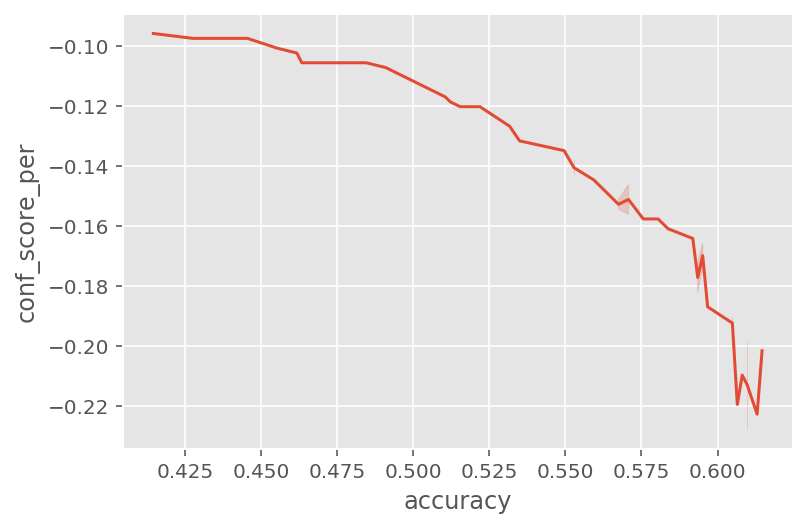

In [81]:
sns.lineplot(tracker.accuracy, -tracker.conf_score_per)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


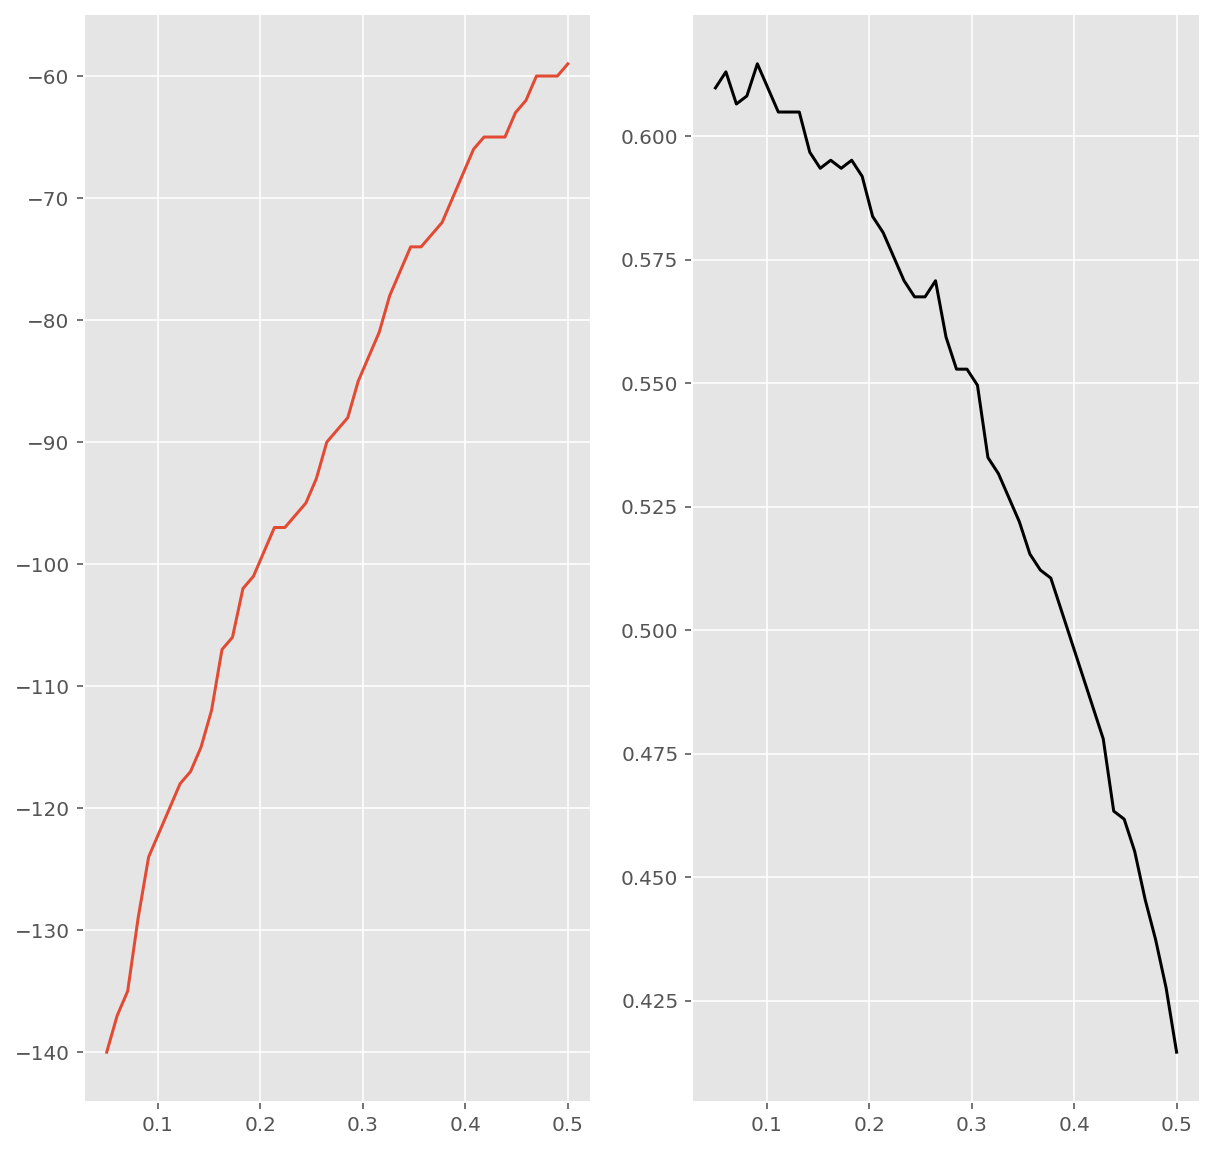

In [85]:
#This plot doesn't really show much because of the difference in axis
fig, ax= plt.subplots(ncols=2, figsize=(10,10))
sns.lineplot(threshold, -np.array(conf_score), ax=ax[0])
sns.lineplot(threshold, accuracy, c='k', ax=ax[1])
plt.show()

##### Finding the optimal penalty for the maximum accuracy for conf_matrix_per below 15%

Class weights are a way for you to penalise certain classes for being wrong and are relative to other classes. The higher the weight for a class, the more emphasis on that class. By default, all the classes have weight 1. I tested a few ranges and ran the Logisitic Regression for the different weights using the optimal paramters from before and scored the max accuracy score and probablity threshold to get the confusion matrix score to below 15%. 

The best weights were {0:1, 1:1, 2:0.888889, 3:0.888889} with an accuracy score of 0.604878 and probability threshold of 0.131818. It improved the accuracy, presumably because it got more of class 0 and 1 right while keeping the confusion matrix percentage below 15%. We can check this in the next section. I also plotted the accuracy score vs penalty to visualise better the relationship.


In [83]:
best_thres = []
best_accuracy = []
#penalties = [1, 2, 3, 4, 5, 1/2, 1/3, 1/4, 1/5]
penalties = np.linspace(0, 2, 100)
#penalties = np.logspace(0, 1, 100)
conf_score_percentage = 0.15

for x in penalties:
    best_logreg = LogisticRegression(solver='liblinear', C=3.1622776601683795, penalty='l2',
                                     multi_class='ovr', class_weight={0: 1, 1: 1, 2: x, 3: x}, verbose=1, n_jobs=2)

    best_logreg.fit(X_train, y_train)

    probabilities = pd.DataFrame(
        best_logreg.predict_proba(X_test), columns=[0, 1, 2, 3])

    conf_score = []
    accuracy = []
    threshold = np.linspace(0.05, 0.5, 45)

    for value in threshold:
        new_pred = []
        for each in probabilities.values:
            pred = np.where(each == each.max())[0]
            if pred == 3:
                if each[pred]-each[pred-1] >= value:
                    new_pred.append(pred[0])
                else:
                    new_pred.append(pred[0]-1)

            elif pred == 2:
                if each[pred]-each[pred-1] >= value:
                    new_pred.append(pred[0])
                else:
                    new_pred.append(pred[0]-1)

            elif pred == 1:
                if each[pred]-each[pred-1] >= value:
                    new_pred.append(pred[0])
                else:
                    new_pred.append(pred[0]-1)
            else:
                new_pred.append(pred[0])

        conf_score.append(np.triu(confusion_matrix(
            y_test, new_pred), k=1).sum().sum())
        accuracy.append(metrics.accuracy_score(y_test, new_pred))

    tracker = pd.DataFrame(list(zip(conf_score, np.array(conf_score)/len(y_test), accuracy, threshold)),
                           columns=['conf_score', 'conf_score_per',  'accuracy', 'threshold'])

    best = tracker[tracker.conf_score_per <
                   conf_score_percentage][['threshold', 'accuracy']].iloc[0]
    best_thres.append(best['threshold'])
    best_accuracy.append(best['accuracy'])

final_tracker = pd.DataFrame(list(zip(best_thres, best_accuracy, penalties)),
                             columns=['threshold', 'accuracy', 'penalty'])
final_tracker.sort_values(by='accuracy')

[LibLinear]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

,threshold,accuracy,penalty
0,0.050000,0.365854,0.000000
1,0.050000,0.416260,0.020202
2,0.050000,0.453659,0.040404
3,0.050000,0.473171,0.060606
4,0.050000,0.487805,0.080808
...,...,...,...
37,0.142045,0.596748,0.747475
40,0.142045,0.598374,0.808081
39,0.142045,0.598374,0.787879
44,0.142045,0.598374,0.888889


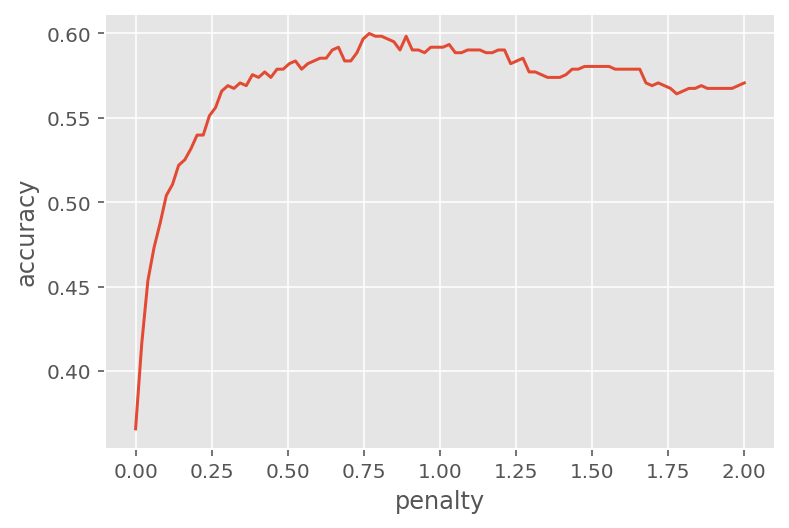

In [84]:
sns.lineplot(final_tracker.penalty, final_tracker.accuracy)
plt.show()

##### Fitting the optimal Log Reg with the optimal weights and probability threshold

I fit the model with the best paramters and confirm using the accuracy score and confusion matrix.

In [806]:
best_logreg = LogisticRegression(solver='liblinear', C=3.1622776601683795, penalty='l2',
                                 multi_class='ovr', class_weight={0: 1, 1: 1, 2: 0.888889, 3: 0.888889}, 
                                 verbose=1, n_jobs=2)

best_logreg.fit(X_train, y_train)

probabilities = pd.DataFrame(best_logreg.predict_proba(X_test), columns=[0, 1, 2, 3])

new_pred = []
value = 0.131818
for each in probabilities.values:
    pred = np.where(each == each.max())[0]
    if pred == 3:
        if each[pred]-each[pred-1] >= value:
            new_pred.append(pred[0])
        else:
            new_pred.append(pred[0]-1)

    elif pred == 2:
        if each[pred]-each[pred-1] >= value:
            new_pred.append(pred[0])
        else:
            new_pred.append(pred[0]-1)

    elif pred == 1:
        if each[pred]-each[pred-1] >= value:
            new_pred.append(pred[0])
        else:
            new_pred.append(pred[0]-1)
    else:
        new_pred.append(pred[0])

probabilities['new'] = new_pred
print(metrics.accuracy_score(y_test, probabilities['new']))

[LibLinear]0.6048780487804878


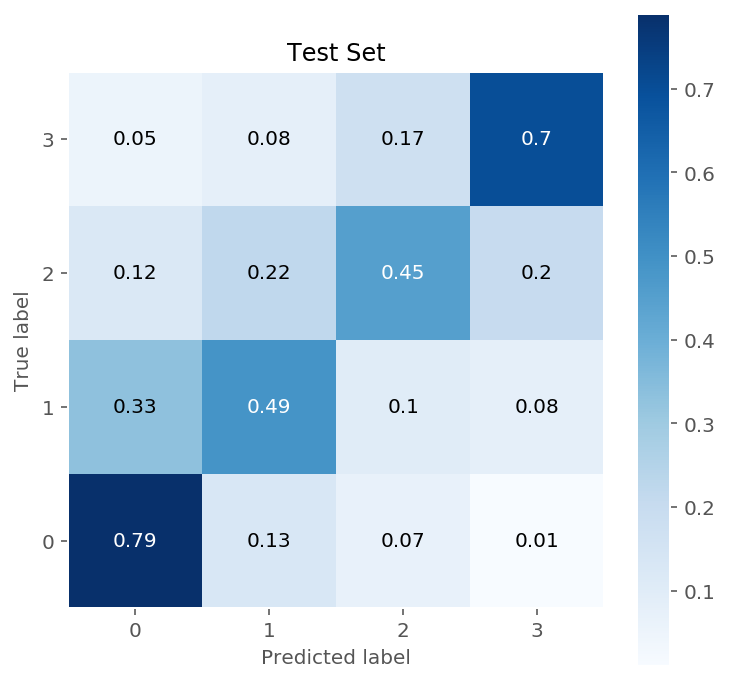

In [808]:
skplt.metrics.plot_confusion_matrix(y_test, probabilities['new'], figsize=(6,6), title = 'Test Set', normalize=True)
plt.ylim([-0.5, len(y_test.unique())-0.5])
plt.show()

In [805]:
conf_mat= np.triu(confusion_matrix(y_test, probabilities['new']), k = 1)
print(conf_mat.sum().sum()/len(y_test), conf_mat.sum().sum())
conf_mat

0.14796747967479676 91


array([[ 0, 19, 10,  2],
       [ 0,  0, 16, 13],
       [ 0,  0,  0, 31],
       [ 0,  0,  0,  0]])

##### Feature Importantance
Just quickly observing the features importances of the different classes. E.g. lead and San Fran seem to positively influence for predicting class 3 (while negatively impacting class 1) while junior and data analyst seem to positively influence class 0.

In [769]:
features = list(X_dum.columns) + list(tvec.get_feature_names())

In [770]:
pd.DataFrame(list(zip(gs_logreg.best_estimator_.coef_[0], abs(gs_logreg.best_estimator_.coef_[0]) )), 
             columns=['coef_0', 'abs_coef_0'], index = features).sort_values(by='abs_coef_0', ascending = False)[:20]

,coef_0,abs_coef_0
city_NYC,-4.294181,4.294181
reports,2.681668,2.681668
business analyst,-2.471421,2.471421
internal,-2.435752,2.435752
city_San Francisco,-2.423647,2.423647
apprentice,2.398854,2.398854
design,-2.301526,2.301526
junior,2.237525,2.237525
support,2.220694,2.220694
head,-2.143784,2.143784


In [771]:
pd.DataFrame(list(zip(gs_logreg.best_estimator_.coef_[1], abs(gs_logreg.best_estimator_.coef_[1]) )), 
             columns=['coef_1', 'abs_coef_1'], index = features).sort_values(by='abs_coef_1', ascending = False)[:20]

,coef_1,abs_coef_1
lead,-2.932075,2.932075
city_San Francisco,-2.814108,2.814108
intelligence,2.572215,2.572215
budget,2.471368,2.471368
sector_university,2.237551,2.237551
head,-2.061448,2.061448
45k,2.042700,2.042700
insight,1.913688,1.913688
design,1.879363,1.879363
reporting,-1.862572,1.862572


In [772]:
pd.DataFrame(list(zip(gs_logreg.best_estimator_.coef_[2], abs(gs_logreg.best_estimator_.coef_[2]) )), 
             columns=['coef_2', 'abs_coef_2'], index = features).sort_values(by='abs_coef_2', ascending = False)[:20]

,coef_2,abs_coef_2
ux,3.009218,3.009218
areas,2.818663,2.818663
techniques,2.591696,2.591696
currently,2.471841,2.471841
60,2.408623,2.408623
support,-2.320517,2.320517
enterprise,2.212754,2.212754
infrastructure,2.139920,2.139920
development,2.131416,2.131416
development new,2.125612,2.125612


In [773]:
pd.DataFrame(list(zip(gs_logreg.best_estimator_.coef_[3], abs(gs_logreg.best_estimator_.coef_[3]) )), 
             columns=['coef_3', 'abs_coef_3'], index = features).sort_values(by='abs_coef_3', ascending = False)[:20]

,coef_3,abs_coef_3
city_San Francisco,4.853342,4.853342
lead,4.639166,4.639166
city_NYC,4.066723,4.066723
head,3.472076,3.472076
actuarial,3.401648,3.401648
devops,3.332616,3.332616
architect,3.120231,3.120231
principal,2.733307,2.733307
health,2.530088,2.530088
fraud,2.478343,2.478343


##### ROC & AUC curves

Plotted the ROC and AUC curves and confirms that the model has more trouble predicting class 1 and 2 correctly. If I had more time, I would have gone back and tried more feature engineering to better seperate the two classes.

In [774]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

In [775]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

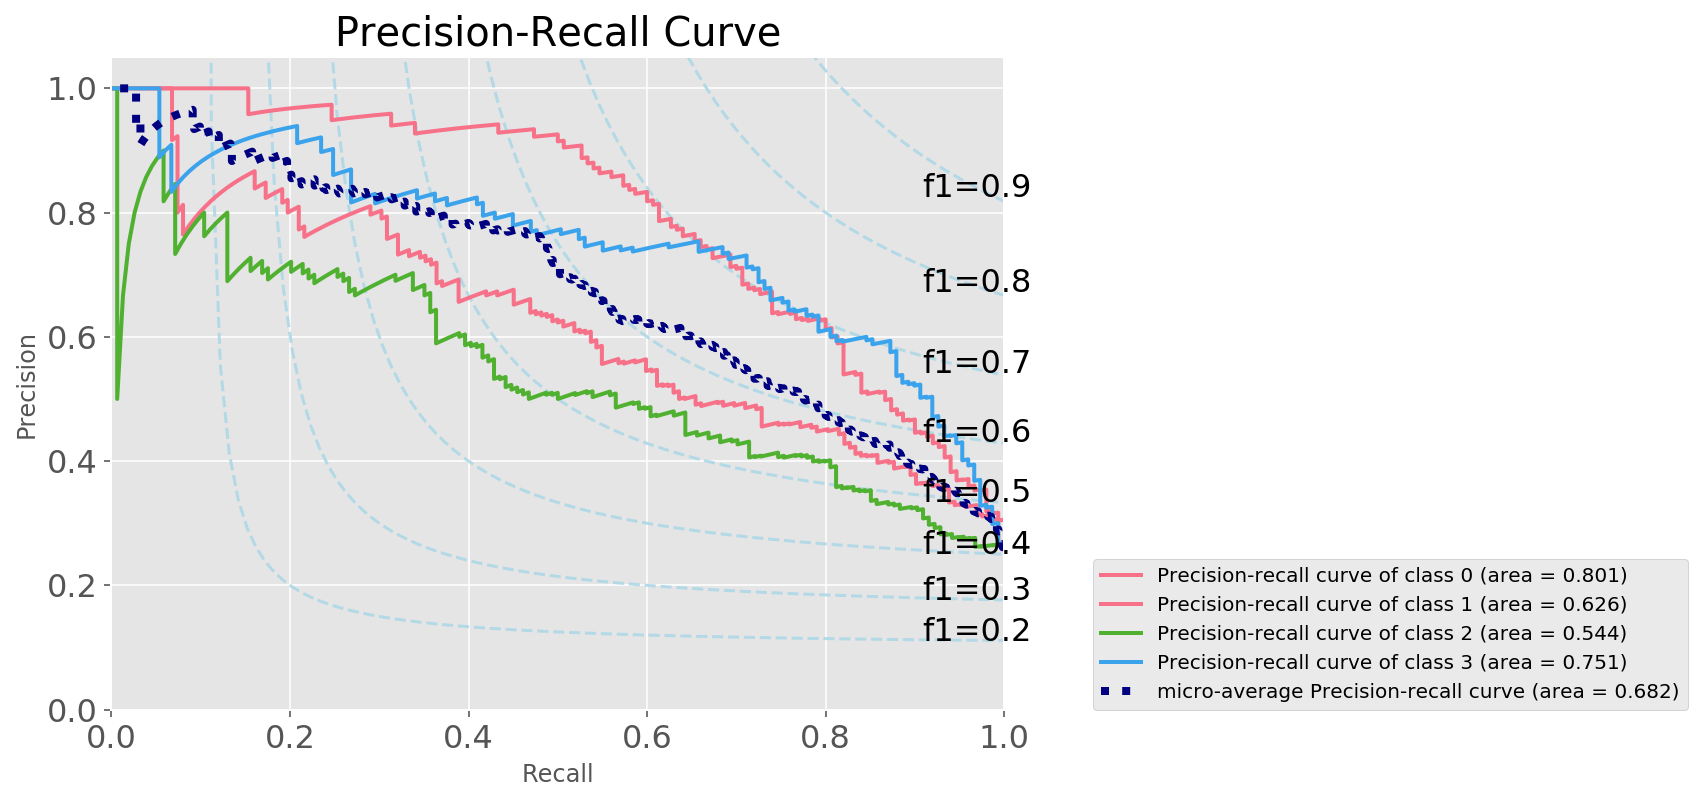

In [776]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, gs_logreg.best_estimator_.predict_proba(X_test), 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

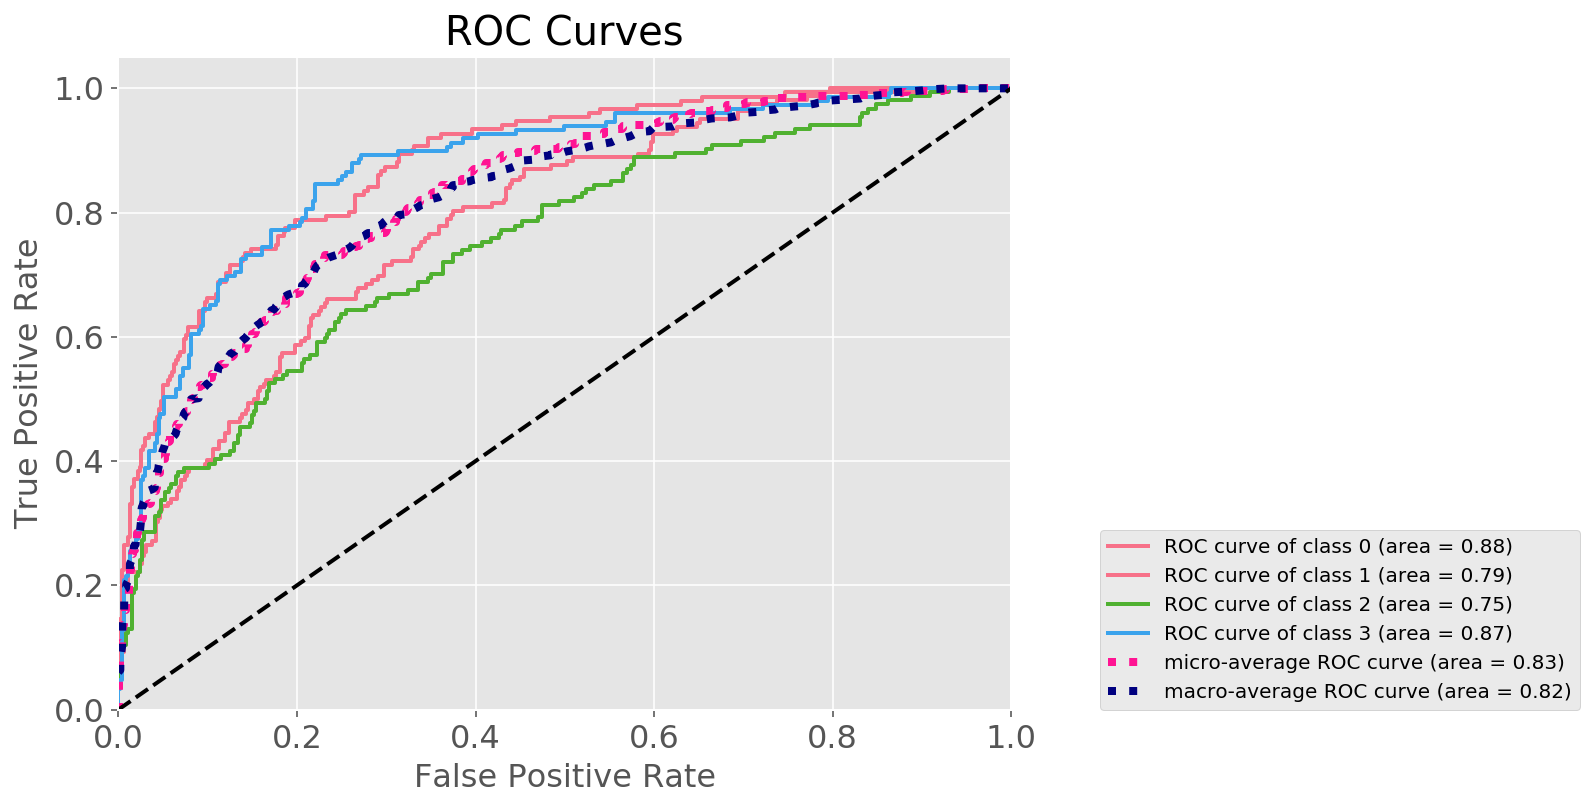

In [276]:
skplt.metrics.plot_roc(y_test, gs_logreg.best_estimator_.predict_proba(X_test), plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap)
plt.legend(loc=[1.1,0])
plt.show()

#### Bagging with Logistic Regression - 0.5765378437898432 - with gridsearch - 157

In [793]:
bagging_lr = BaggingClassifier(gs_logreg.best_estimator_, n_estimators = 100, random_state=1)
bagging_lr.fit(X_train, y_train)
print(bagging_lr.score(X_train, y_train))
print(bagging_lr.score(X_test, y_test))
print(cross_val_score(bagging_lr, X_train, y_train, cv = 5).mean())

0.9328175895765473
0.6032520325203252
0.5765378437898432


In [144]:
params = {'base_estimator__penalty': ['l1', 'l2'],
         'max_samples': np.linspace(0.8, 1.0, 3),
          'max_features': np.linspace(0.6, 1.0, 3),
         'n_estimators': [100, 150, 200]}
         #'base_estimator__max_leaf_nodes': range(805, 1056, 50)}

gs_bagging_lr = GridSearchCV(bagging_lr, param_grid=params, cv=3, n_jobs=2, verbose = 1)
gs_bagging_lr.fit(X_train, y_train)
gs_bagging_lr.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.3min
[Parallel(n_jobs=2)]: Done 162 out of 162 | elapsed: 23.2min finished


BaggingClassifier(base_estimator=LogisticRegression(C=3.1622776601683795,
                                                    class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='ovr',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=0.6,
                  max_samples=1.0, n_estimators=

In [145]:
gs_bagging_lr.best_score_

0.5738570749773041

In [146]:
gs_bagging_lr.best_params_

{'base_estimator__penalty': 'l2',
 'max_features': 0.6,
 'max_samples': 1.0,
 'n_estimators': 150}

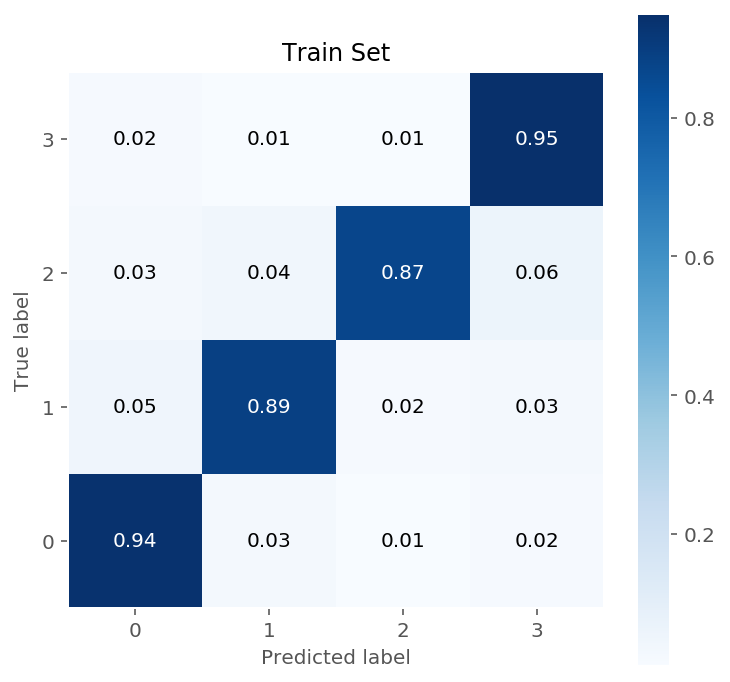

In [188]:
skplt.metrics.plot_confusion_matrix(y_train, gs_bagging_lr.best_estimator_.predict(X_train), figsize=(6,6), title = 'Train Set', normalize = True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

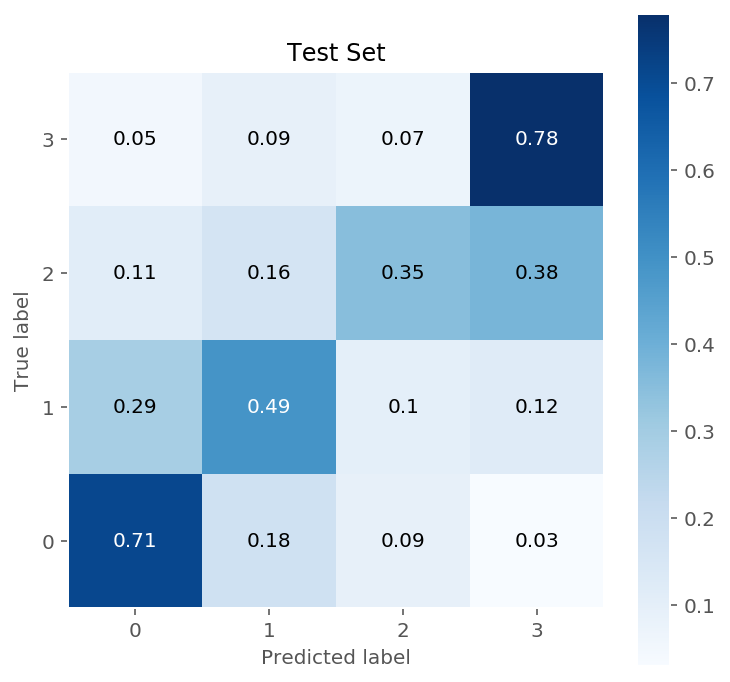

In [189]:
skplt.metrics.plot_confusion_matrix(y_test, gs_bagging_lr.best_estimator_.predict(X_test), figsize=(6,6), title = 'Test Set', normalize = True)
plt.ylim([-0.5, len(y_test.unique())-0.5])
plt.show()

In [789]:
conf_mat= np.triu(confusion_matrix(y_test, gs_bagging_lr.best_estimator_.predict(X_test)), k = 1)
conf_mat.sum().sum()

157

#### Simple Decision Tree - 0.5121596662214086 - without gridsearch - 127

In [794]:
dc = DecisionTreeClassifier(criterion='gini',
                                    random_state=1)
dc.fit(X_train, y_train)
print(dc.score(X_train, y_train))
print(dc.score(X_test, y_test))
print(cross_val_score(dc, X_train, y_train, cv=5).mean())

1.0
0.5024390243902439
0.49592336860232145


In [107]:
dc.tree_.node_count

1299

In [108]:
'''from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtr1
# for feature_names i put the columns of my Xr matrix
export_graphviz(classifier, out_file=dot_data,  
                 filled=True, rounded=True,
                 special_characters=True,
                 feature_names=X_test.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())'''

'from six import StringIO  \nfrom IPython.display import Image  \nfrom sklearn.tree import export_graphviz\nimport pydotplus\n\n# initialize the output file object\ndot_data = StringIO() \n\n# my fit DecisionTreeRegressor object here is: dtr1\n# for feature_names i put the columns of my Xr matrix\nexport_graphviz(classifier, out_file=dot_data,  \n                 filled=True, rounded=True,\n                 special_characters=True,\n                 feature_names=X_test.columns)  \n\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())'

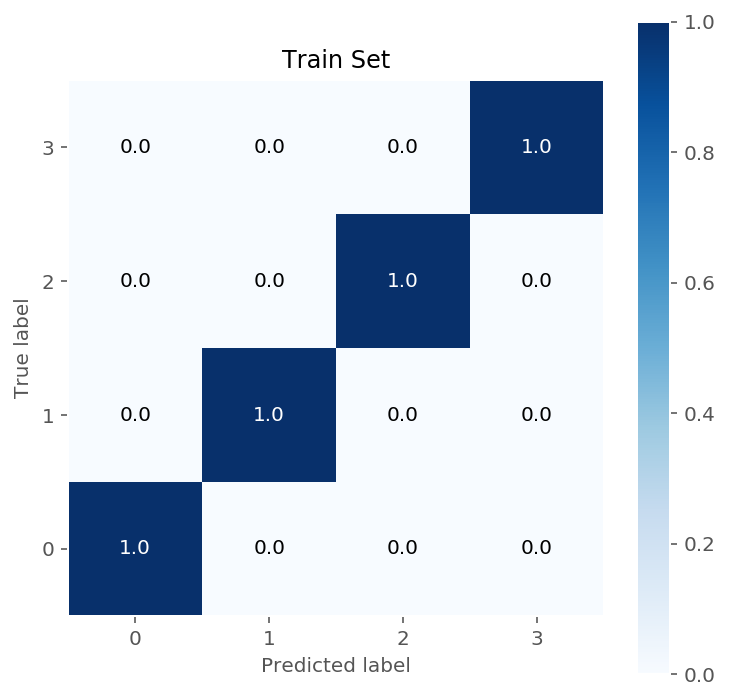

In [109]:
skplt.metrics.plot_confusion_matrix(y_train, dc.predict(X_train), figsize=(6,6), title = 'Train Set', normalize = True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

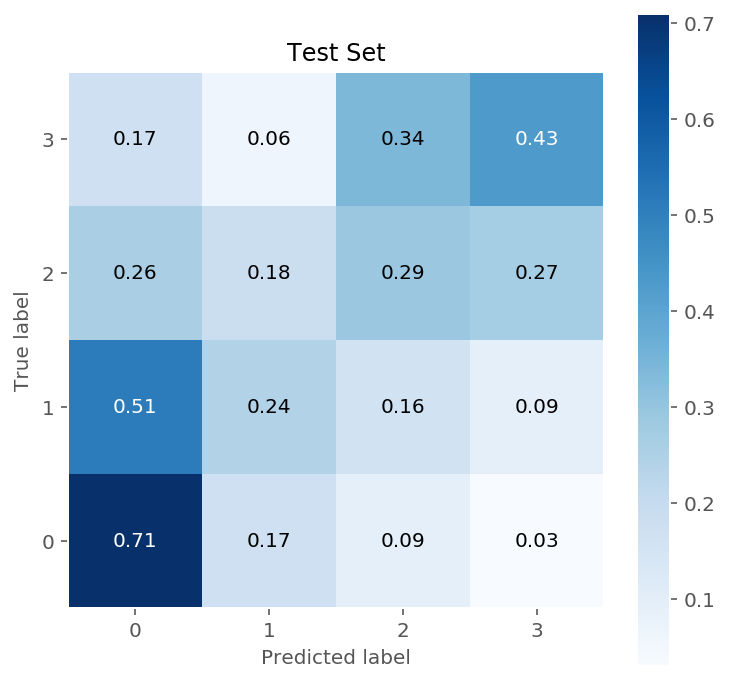

In [787]:
skplt.metrics.plot_confusion_matrix(y_test, dc.predict(X_test), figsize=(6,6), title = 'Test Set', normalize=True)
plt.ylim([-0.5, len(y_test.unique())-0.5])
plt.show()

In [788]:
conf_mat= np.triu(confusion_matrix(y_test, dc.predict(X_test)), k = 1)
conf_mat.sum().sum()

127

#### Bagging with Deep Descision Trees - 0.5754865439156449 - with gridesearch - 127

In [123]:
bagging = BaggingClassifier(dc, n_estimators = 150, random_state=1, max_samples = 0.8, max_features = 0.6)
bagging.fit(X_train, y_train)
print(bagging.score(X_train, y_train))
print(bagging.score(X_test, y_test))
print(cross_val_score(bagging, X_train, y_train, cv = 3).mean())

1.0
0.5535714285714286
0.5754865439156449


In [112]:
nodes = dc.tree_.node_count

In [113]:
3/4.*nodes

974.25

In [114]:
nodes

1299

In [116]:
bagging = BaggingClassifier(base_estimator=dc, n_estimators=100, random_state=1)
params = {'max_samples': np.linspace(0.8, 1.0, 3),
          'max_features': np.linspace(0.6, 1.0, 3),
         'n_estimators': range(100, 250, 50)}
         #'base_estimator__max_leaf_nodes': range(805, 1056, 50)}

gs_bagging = GridSearchCV(bagging, param_grid=params, cv=3, n_jobs=2, verbose = 1)
gs_bagging.fit(X_train, y_train)
gs_bagging.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.5min
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed: 16.3min finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=1,
   

In [ ]:
"""check = []
for item in pd.DataFrame(gs_bagging.cv_results_)['params']:
    check.append(item['base_estimator__max_leaf_nodes'])

np.unique(check)"""

In [117]:
print(gs_bagging.best_estimator_.score(X_train, y_train))
print(gs_bagging.best_estimator_.score(X_test, y_test))
print(gs_bagging.best_score_)

1.0
0.5535714285714286
0.5754865439156449


In [118]:
gs_bagging.best_params_

{'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 150}

In [124]:
nodes = []
for each in gs_bagging.best_estimator_.estimators_:
    nodes.append(each.tree_.node_count)
np.unique(nodes)

array([827, 829, 843, 849, 851, 855, 863, 865, 871, 873, 875, 877, 879,
       881, 885, 887, 891, 893, 895, 897, 899, 901, 903, 905, 907, 909,
       911, 913, 915, 917, 919, 921, 923, 925, 927, 929, 931, 933, 935,
       937, 939, 941, 943, 945, 947, 949, 951, 953, 955, 957, 959, 961,
       963, 965, 971, 973, 975, 983, 991])

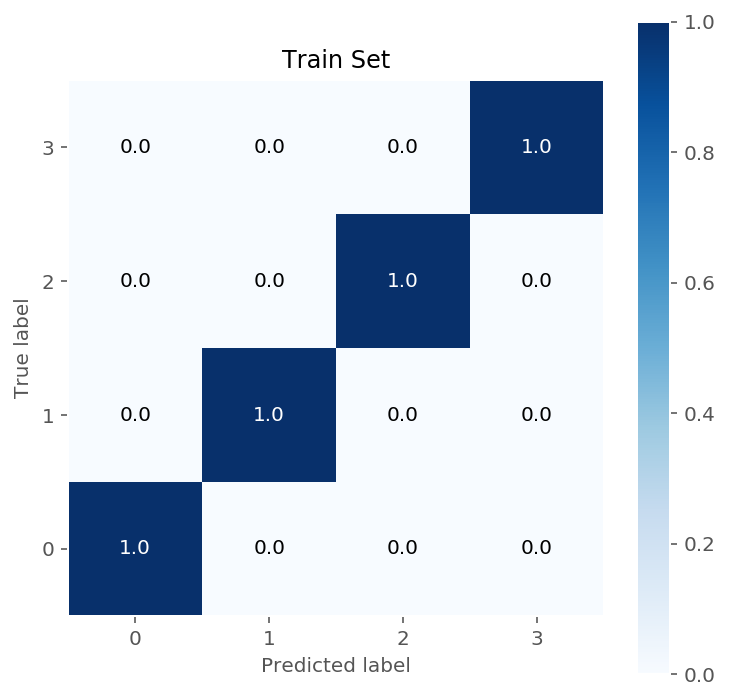

In [125]:
cmap = ListedColormap(sns.color_palette("husl", 4))
skplt.metrics.plot_confusion_matrix(y_train, gs_bagging.best_estimator_.predict(X_train), figsize=(6,6), title = 'Train Set', normalize = True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

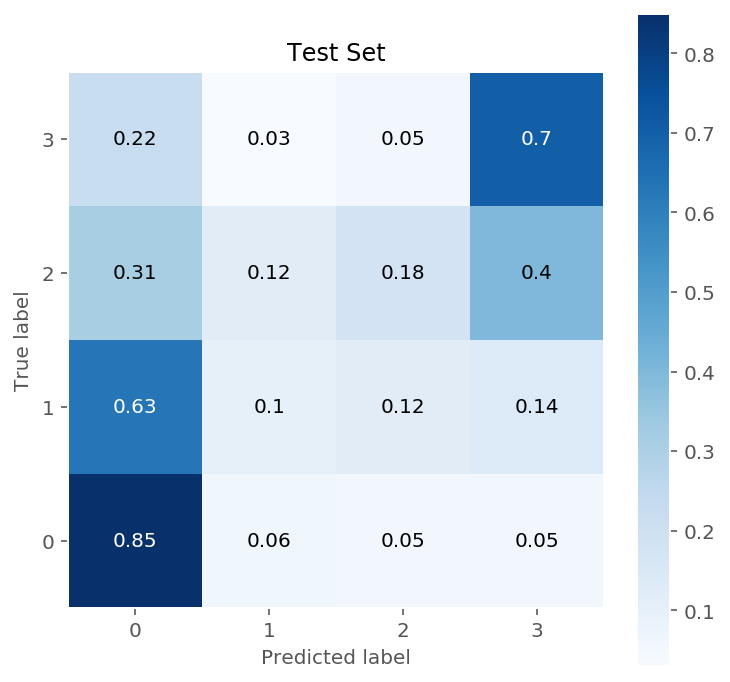

In [784]:
cmap = ListedColormap(sns.color_palette("husl", 4))
skplt.metrics.plot_confusion_matrix(y_test, gs_bagging.best_estimator_.predict(X_test), figsize=(6,6), title = 'Test Set', normalize = True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

In [785]:
conf_mat= np.triu(confusion_matrix(y_test, gs_bagging.best_estimator_.predict(X_test)), k = 1)
conf_mat.sum().sum()

127

#### Random Forests - 0.5653284190042712 - with gridsearch - 177

In [140]:
rf = RandomForestClassifier(n_estimators = 200, max_samples = 0.9, max_features = 0.8, random_state=1)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
print(cross_val_score(rf, X_train, y_train, cv = 3).mean())

1.0
0.5438311688311688
0.563312203087446


In [139]:
gs_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.8,
                       max_leaf_nodes=None, max_samples=0.9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [128]:
rf.n_features_

15022

In [135]:
params = {'max_samples': np.linspace(0.8, 1.0, 3),
          'max_features': [0.6, 0.8, 1.0],
         'n_estimators': range(100, 201, 50)}
          #'max_leaf_nodes': range(int((3/4)*nodes), nodes+1, 50)}

gs_rf = GridSearchCV(rf, param_grid=params, cv=3, n_jobs=2, verbose = 1)
gs_rf.fit(X_train, y_train)
gs_rf.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:  9.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.8,
                       max_leaf_nodes=None, max_samples=0.9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [136]:
print(gs_rf.best_estimator_.score(X_train, y_train))
print(gs_rf.best_estimator_.score(X_test, y_test))
print(gs_rf.best_score_)

1.0
0.5438311688311688
0.563312203087446


In [137]:
gs_rf.best_params_

{'max_features': 0.8, 'max_samples': 0.9, 'n_estimators': 200}

In [253]:
gs_rf.best_estimator_.estimators_

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=17, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1791095845, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=17, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=2135392491, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_feat

In [256]:
feature_importances = gs_rf.best_estimator_.feature_importances_
pd.DataFrame(list(zip(X_train.columns, feature_importances)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)

,Feature,Importance
7,analyst,0.076353
21,rating_t_None,0.075963
20,rating_t_Medium,0.060606
0,senior,0.058640
1,junior,0.056351
11,city_London,0.055423
16,sector_recruitment,0.055360
18,sector_unknown,0.054481
5,other_engineer,0.051849
6,data_science,0.050064


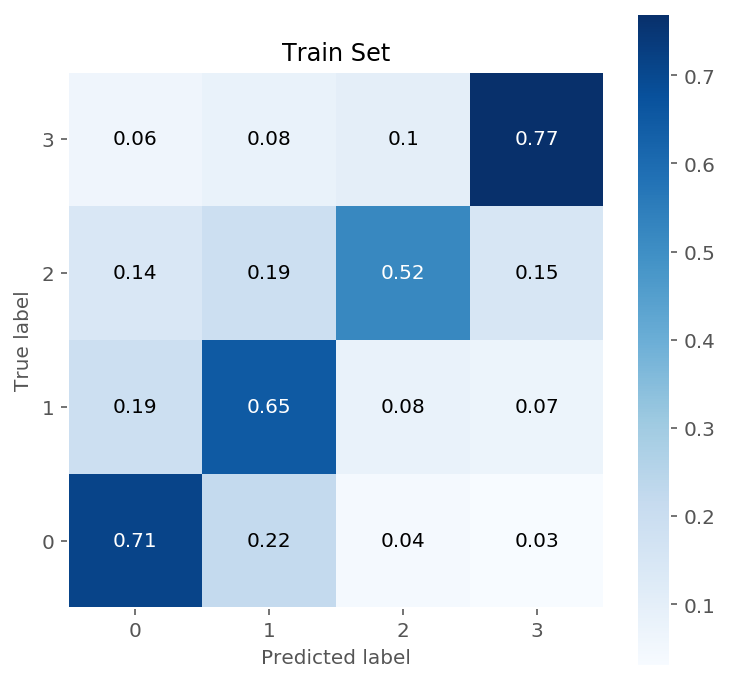

In [257]:
skplt.metrics.plot_confusion_matrix(y_train, gs_rf.best_estimator_.predict(X_train), figsize=(6,6), title = 'Train Set', normalize = True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

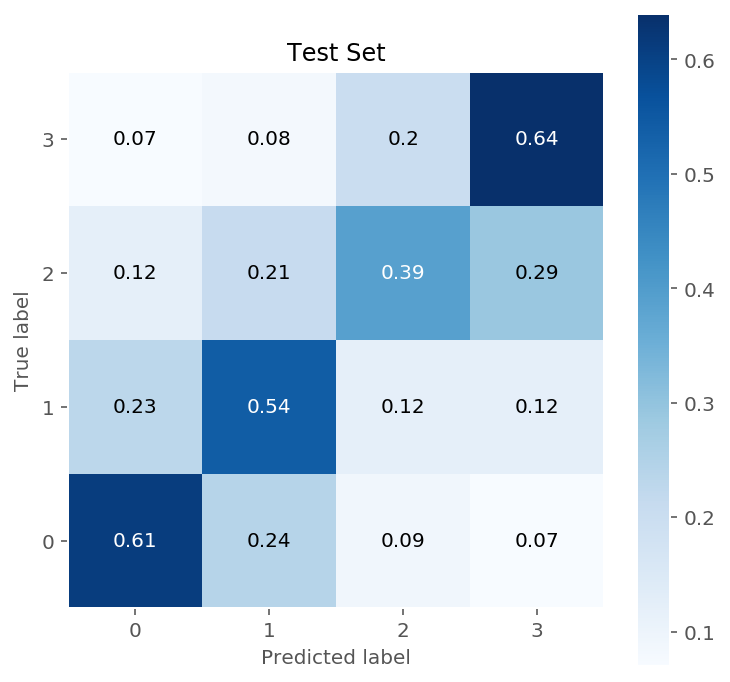

In [350]:
skplt.metrics.plot_confusion_matrix(y_test, gs_rf.best_estimator_.predict(X_test), figsize=(6,6), title = 'Test Set', normalize = True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

In [780]:
conf_mat= np.triu(confusion_matrix(y_test, gs_rf.best_estimator_.predict(X_test)), k = 1)
print(conf_mat.sum().sum())
conf_mat

177


array([[ 0, 23, 31,  4],
       [ 0,  0, 57, 16],
       [ 0,  0,  0, 46],
       [ 0,  0,  0,  0]])

#### Descision Tree with Gradient Boosting - 0.5413892025332587 - with gridsearch - 168

In [132]:
gb = GradientBoostingClassifier(
    n_estimators=400,
    criterion='mse',
    max_depth=3,
    learning_rate=0.1,
    random_state=1, validation_fraction=0.1, n_iter_no_change=20)

gb.fit(X_train, y_train)

print(gb.score(X_train, y_train))
print(gb.score(X_test, y_test))
print(cross_val_score(gb, X_train, y_train, cv=3).mean())


0.9001623376623377
0.5665584415584416
0.5239431666523428


In [133]:
params = {'subsample': np.linspace(0.8, 1.0, 3),
          'max_features': ['auto', 0.7, 1.0],
         'n_estimators': range(300, 401, 50), 
          'learning_rate': [0.1, 0.5]}
#          'max_depth':[2, 3]
        
         

gs_gb = GridSearchCV(gb, param_grid=params, cv=3, n_jobs=2, verbose = 2)
gs_gb.fit(X_train, y_train)
gs_gb.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 12.4min
[Parallel(n_jobs=2)]: Done 162 out of 162 | elapsed: 12.6min finished


GradientBoostingClassifier(ccp_alpha=0.0, criterion='mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.7, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=20, presort='deprecated',
                           random_state=1, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [134]:
print(gs_gb.best_estimator_.score(X_train, y_train))
print(gs_gb.best_estimator_.score(X_test, y_test))
print(gs_gb.best_score_)
gs_gb.best_params_

0.9212662337662337
0.5324675324675324
0.5413892025332587


{'learning_rate': 0.1,
 'max_features': 0.7,
 'n_estimators': 300,
 'subsample': 0.8}

{'learning_rate': 0.1,
 'max_features': 0.7,
 'n_estimators': 300,
 'subsample': 0.8}


In [269]:
feature_importances = gs_gb.best_estimator_.feature_importances_
pd.DataFrame(list(zip(X_train.columns, feature_importances)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)

,Feature,Importance
0,senior,0.093836
1,junior,0.093719
11,city_London,0.087618
13,city_NYC,0.087156
2,head,0.071711
7,analyst,0.067626
6,data_science,0.060558
14,city_San Francisco,0.057513
4,data_engineer,0.055832
3,ai,0.044510


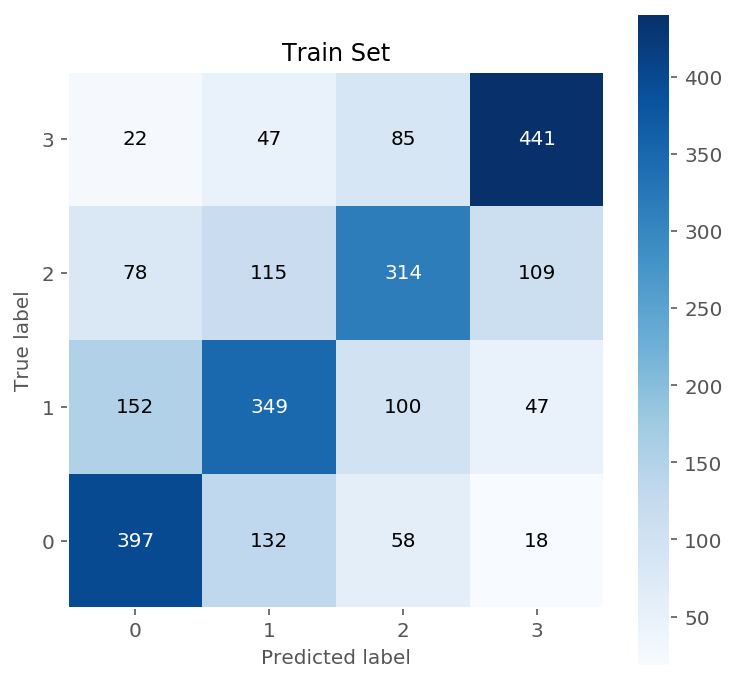

In [280]:
skplt.metrics.plot_confusion_matrix(y_train, gs_gb.best_estimator_.predict(X_train), figsize=(6,6), title = 'Train Set')
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

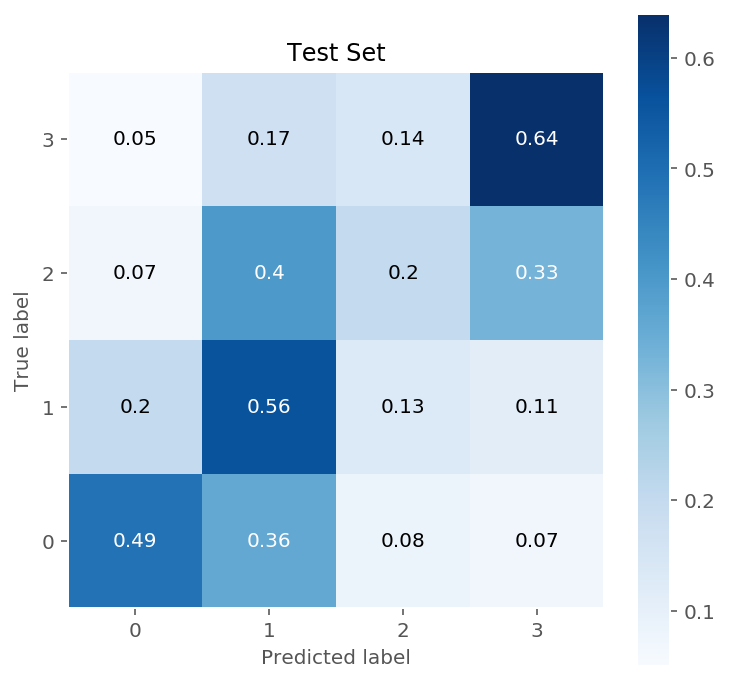

In [781]:
skplt.metrics.plot_confusion_matrix(y_test, gs_gb.best_estimator_.predict(X_test), figsize=(6,6), title = 'Test Set', normalize = True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

In [782]:
conf_mat= np.triu(confusion_matrix(y_test, gs_gb.best_estimator_.predict(X_test)), k = 1)
conf_mat.sum().sum()

167

#### Decision Trees with Ada Boosting - 0.474428352265599 - without gridsearch - 198

In [171]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                           n_estimators=400, learning_rate = 0.1,
                           random_state=1)
ada.fit(X_train, y_train)

print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))
print(cross_val_score(ada, X_train, y_train, cv=3).mean())


0.8299512987012987
0.48863636363636365
0.474428352265599


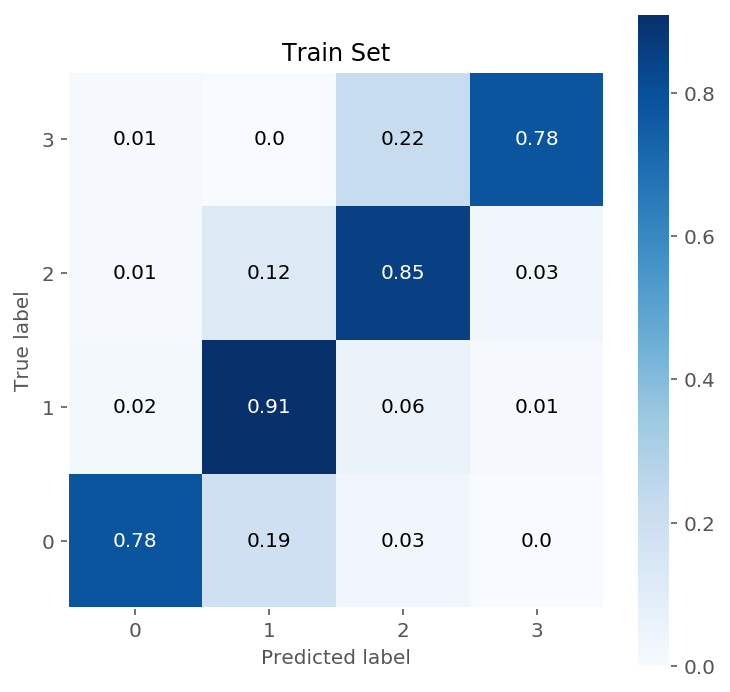

In [174]:
skplt.metrics.plot_confusion_matrix(y_train, ada.predict(X_train), figsize=(6,6), title = 'Train Set', normalize=True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

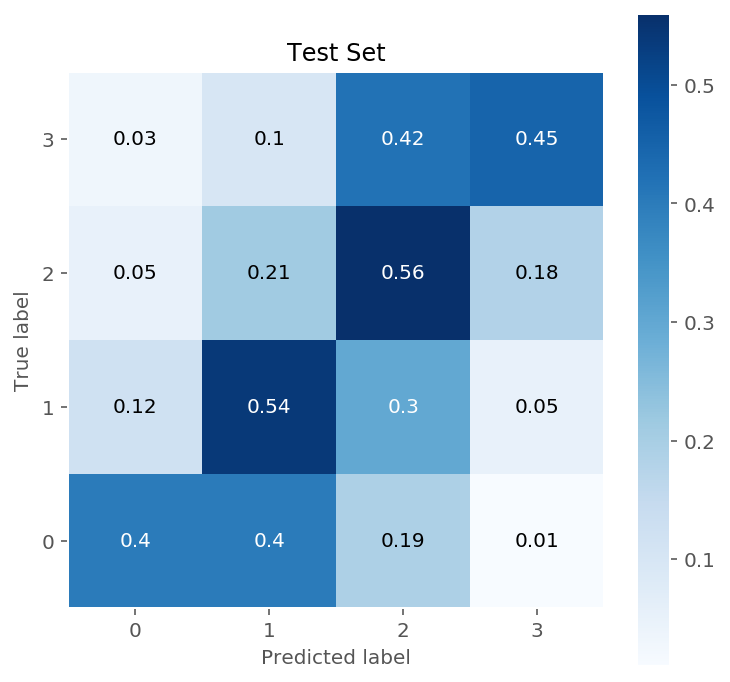

In [173]:
skplt.metrics.plot_confusion_matrix(y_test, ada.predict(X_test), figsize=(6,6), title = 'Test Set', normalize = True)
plt.ylim([-0.5, len(y_train.unique())-0.5])
plt.show()

In [783]:
conf_mat= np.triu(confusion_matrix(y_test, ada.predict(X_test)), k = 1)
conf_mat.sum().sum()

198